In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

<IPython.core.display.Javascript object>

In [3]:
def convert_to_float(value):
    try:
        # If it's a string enclosed in single quotes, remove quotes and replace comma with dot
        if isinstance(value, str):
            return float(value.replace(",", "."))
        else:
            return float(value)
    except ValueError as e:
        print(e)
        return float("nan")

<IPython.core.display.Javascript object>

In [4]:
def preprocess_numeric_cols(df, columns):
    for col in columns:
        df[col] = df[col].astype(str)  # Ensure string type for string operations
        df[col] = df[col].str.replace("#", "")  # Remove '#' characters
        df[col] = df[col].str.replace(",", ".")  # Replace ',' with '.' for decimals
    return df

<IPython.core.display.Javascript object>

In [5]:
def check_columns_match(df1, df2):
    """
    Check if two dataframes have the same columns in the same order.
    """

    df1_cols = set(df1.columns)
    df2_cols = set(df2.columns)

    same_cols = df1_cols == df2_cols

    print(f"Dataframes have the same columns: {same_cols}")

    same_order = all(df1.columns[i] == df2.columns[i] for i in range(len(df1.columns)))

    print(f"Dataframes have the same column order: {same_order}")

    return same_cols, same_order

<IPython.core.display.Javascript object>

# 203

## Reading the dataset

In [6]:
plants = ["AV", "C", "D", "G", "M", "Y"]
xls_files = {}

for plant in plants:
    xls = pd.ExcelFile(
        f"../../../../data/raw/203/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
        engine="openpyxl",
    )
    xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [7]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [8]:
for plant, xls in xls_files.items():
    print("Plant: ", plant, xls.sheet_names)

Plant:  AV ['INSTRUÇÕES', '122', '24', '134', '50']
Plant:  C ['INSTRUÇÕES', '114', '36', '144', '74', '54']
Plant:  D ['INSTRUÇÕES', '10', '131', '117', '197', '8']
Plant:  G ['INSTRUÇÕES', '3', '160', '49', '137', '2', '17', '142']
Plant:  M ['INSTRUÇÕES', '147', '141', '159', '73', '170', '53', '135', '67', '161']
Plant:  Y ['INSTRUÇÕES', '77', '151', '179', '136', '71', '113']


<IPython.core.display.Javascript object>

In [9]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [10]:
df = pd.concat(
    [
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name 

In [11]:
COLUMNS_TO_DROP = [
    ("Data", "Produção"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
]

COLUMNS_TO_RENAME = {
    ("Cidade", "Unnamed: 1_level_2"): "Plant",
    ("Data", "Medida"): "Date",
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [12]:
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

<IPython.core.display.Javascript object>

### Replacing the current cement type categories for a short identifiable category

In [13]:
# Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("FIBROCMENTO", "Fibrocimento")
df["Cement_Type"] = df["Cement_Type"].replace("CP VARIEnsacado", "CP VARI")
df["Cement_Type"] = df["Cement_Type"].replace("CP VARIGranel", "CP VARI")
df["Cement_Type"] = df["Cement_Type"].replace("CP III40Ensacado", "CP III40")
df["Cement_Type"] = df["Cement_Type"].replace("CP III40Granel", "CP III40")
df["Cement_Type"] = df["Cement_Type"].replace("CP VARIRS", "CP VARI")

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [14]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Clean and converting numeric columns to float

In [15]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '1..10'
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: '             '
could not convert string to float: '  '
could not convert string to float: ' '
could not convert string to float: '1.6.0'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
coul

<IPython.core.display.Javascript object>

### Converting Date columns to pandas datetime

In [16]:
df["Date"] = pd.to_datetime(df["Date"])

<IPython.core.display.Javascript object>

In [17]:
df.shape

(20203, 25)

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [18]:
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [19]:
df.shape

(19506, 25)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [20]:
df["Factory_Plant"] = "203_" + df["Plant"]
df = df.drop("Plant", axis=1)

<IPython.core.display.Javascript object>

In [21]:
df_203 = df.copy()

<IPython.core.display.Javascript object>

# 204

In [22]:
plants = ["A", "AB", "AE", "AQ", "AY", "F", "I", "O", "R", "T"]
xls_files = {}

for plant in plants:
    xls = pd.ExcelFile(
        f"../../../../data/raw/204/EMBRAPII hubIC IACC CIMENTO_{plant}.xlsx",
        engine="openpyxl",
    )
    xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [23]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])
        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [24]:
for plant, xls in xls_files.items():
    print("Palnt: ", plant, xls.sheet_names)

Palnt:  A ['INSTRUÇÕES', '176', '102']
Palnt:  AB ['INSTRUÇÕES', '13', '51', '173']
Palnt:  AE ['INSTRUÇÕES', '181', '109', '23']
Palnt:  AQ ['INSTRUÇÕES', 'Fibro', '7', '153', '89']
Palnt:  AY ['INSTRUÇÕES', '12']
Palnt:  F ['INSTRUÇÕES', '55', '75', '14', '91', '65']
Palnt:  I ['INSTRUÇÕES', '47', '11', '1']
Palnt:  O ['INSTRUÇÕES', '132', '81', 'FIBRO']
Palnt:  R ['INSTRUÇÕES', '21', '61']
Palnt:  T ['INSTRUÇÕES', '72', '104']


<IPython.core.display.Javascript object>

In [25]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [26]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [27]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [28]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
]


COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",  # Arrumar!
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [29]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

# # Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("Fibro", "Fibrocimento")

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [30]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [31]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

### Dropping variable with City and Plant identification

In [32]:
df["Factory_Plant"] = "204_" + df["Plant"]
FEATRUES_TO_DROP = ["City", "Plant"]
df = df.drop(labels=FEATRUES_TO_DROP, axis=1)

<IPython.core.display.Javascript object>

In [33]:
df.shape

(16000, 25)

<IPython.core.display.Javascript object>

In [34]:
df_204 = df.copy()

<IPython.core.display.Javascript object>

In [35]:
check_columns_match(df_203, df_204)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# 206

In [36]:
plant = "B"
xls_files = {}


xls = pd.ExcelFile(
    f"../../../../data/raw/206/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
    engine="openpyxl",
)
xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [37]:
print("Plant: ", plant, xls.sheet_names)

Plant:  B ['127', '90', 'RX']


<IPython.core.display.Javascript object>

In [38]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names:
        if sheet_name == "RX":
            continue
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])

        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[3:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[3:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [39]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names:
        if sheet_name == "RX":
            continue
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [40]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [41]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [42]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Cidade", "Unnamed: 1_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Unnamed: 83_level_1", "Obs."),
    ("Obs.", "Unnamed: 8_level_2"),
    ("Obs.", "Unnamed: 90_level_2"),
    "Obs.",
]

COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",
    ("Unnamed: 78_level_1", "Blaine"): "Blaine",
    ("Unnamed: 79_level_1", "#200"): "#200",
    ("Unnamed: 80_level_1", "#325"): "#325",
    ("Unnamed: 81_level_1", "#400"): "#400",
    ("Unnamed: 82_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [43]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [44]:
df = df[(df["Cement_Type"] != "ManualManual")]
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [45]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

df = df.reset_index(drop=True)
# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

In [46]:
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [47]:
df["Factory_Plant"] = "206_" + df["Plant"]
df = df.drop("Plant", axis=1)

<IPython.core.display.Javascript object>

In [48]:
df_206 = df.copy()

<IPython.core.display.Javascript object>

In [49]:
check_columns_match(df_203, df_204)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

In [50]:
check_columns_match(df_203, df_206)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# 207

In [51]:
plant = "AT"
xls_files = {}

xls = pd.ExcelFile(
    f"../../../../data/raw/207/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
    engine="openpyxl",
)
xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [52]:
print("Plant: ", plant, xls.sheet_names)

Plant:  AT ['INSTRUÇÕES', '98', '195', '5']


<IPython.core.display.Javascript object>

In [53]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])
        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [54]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[1:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [55]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [56]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [57]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
]

COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",  # Arrumar!
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [58]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

# # Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("Fibro", "Fibrocimento")

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

In [59]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [60]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)

# Filling with cement type due problems with given excel file
index = df[df["Cement_Type"] == ""].index
df.loc[index, "Cement_Type"] = "CPVARI"

df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [61]:
index_to_keep = (
    df.drop(["Plant", "City", "Date", "Cement_Type"], axis=1)
    .dropna(axis=0, how="all")
    .index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [62]:
df.shape

(3002, 26)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [63]:
df["Factory_Plant"] = "207_" + df["Plant"]
df = df.drop(["Plant", "City"], axis=1)

<IPython.core.display.Javascript object>

In [64]:
df_207 = df.copy()

<IPython.core.display.Javascript object>

In [65]:
check_columns_match(df_203, df_207)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

In [66]:
check_columns_match(df_204, df_207)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

In [67]:
check_columns_match(df_206, df_207)

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# 209

In [68]:
plants = [
    "X",
    "H",
    "AS",
    "AG",
    "AW",
    "AZ",
    "W",
    "V",
    "AX",
    "L",
    "N",
    "AI",
    "AA",
    "P",
    "Q",
    "AP",
    "E",
    "AN",
    "AC",
    "K",
    "S",
    "U",
    "J",
    "AM",
    "Z",
]
xls_files = {}

for plant in plants:
    xls = pd.ExcelFile(
        f"../../../../data/raw/209/EMBRAPII hubIC IACC_CIMENTO_{plant}.xlsx",
        engine="openpyxl",
    )
    xls_files[plant] = xls

<IPython.core.display.Javascript object>

In [69]:
for plant, xls in xls_files.items():
    print("Palnt: ", plant, xls.sheet_names)

Palnt:  X ['INSTRUÇÕES', 'Clínquer', '78', '83', '19']
Palnt:  H ['INSTRUÇÕES', 'Clínquer', '119', '76', '87']
Palnt:  AS ['INSTRUÇÕES', 'Clínquer', '31', '63']
Palnt:  AG ['INSTRUÇÕES', 'Clínquer', '146', '115', '166']
Palnt:  AW ['INSTRUÇÕES', 'Clínquer', '88']
Palnt:  AZ ['INSTRUÇÕES', 'Clínquer', '4', '92', '70', '111', '156']
Palnt:  W ['INSTRUÇÕES', 'Clínquer', '140', '196', '163']
Palnt:  V ['INSTRUÇÕES', 'Clínquer', '93']
Palnt:  AX ['INSTRUÇÕES', 'Clínquer', '152', '108', '118']
Palnt:  L ['INSTRUÇÕES', 'Clínquer', '6', '39', '16']
Palnt:  N ['INSTRUÇÕES', 'Clínquer', '80', '66', '94']
Palnt:  AI ['INSTRUÇÕES', 'Clínquer', '79', '27', '120']
Palnt:  AA ['INSTRUÇÕES', 'Clínquer', '95', '110', '133', '145']
Palnt:  P ['INSTRUÇÕES', 'Clínquer', '175']
Palnt:  Q ['INSTRUÇÕES', 'Clínquer', '56', '32', '101', '143']
Palnt:  AP ['INSTRUÇÕES', 'Clínquer', '191', '189', '199', '41']
Palnt:  E ['INSTRUÇÕES', 'Clínquer', '121', '178']
Palnt:  AN ['INSTRUÇÕES', 'Clínquer', '112', '172']
P

<IPython.core.display.Javascript object>

In [70]:
cement_types_per_plant = []
CEMENT_TYPE_COLS = ["Tipo de cimento", "Classe de resistência"]
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[2:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[1, 2])

        if not df[CEMENT_TYPE_COLS].iloc[2:].isna().all().all():
            cement_type = (
                df[CEMENT_TYPE_COLS]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .str.replace("nan", "")
                .unique()
            )

        else:
            cement_type = (
                df[[("Obs.", "Unnamed: 8_level_1")]]
                .loc[2:]
                .astype(str)
                .sum(axis=1)
                .str.replace(" ", "")
                .str.replace("-", "")
                .unique()
            )

        cement_types_per_plant.append((plant, sheet_name, cement_type))
        dataframes.append(df)

<IPython.core.display.Javascript object>

In [71]:
dataframes = []

for plant, xls in xls_files.items():
    for sheet_name in xls.sheet_names[2:]:
        df = pd.read_excel(xls_files[plant], sheet_name, header=[0, 1, 2])
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"] = plant
        dataframes.append(df.drop([0, 1], axis=0).reset_index(drop=True).copy())

<IPython.core.display.Javascript object>

In [72]:
df = pd.concat(dataframes, axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [73]:
df = pd.concat(
    [
        df["Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"],
        df["Dados iniciais"],
        df["Cimento"]["Composição"].rename(
            {"Sulfato de cálcio": "Sulfato de cálcio (composição)"}, axis=1
        ),
        df["Cimento"]["Análise mineralógica"],
        df["Cimento"]["Análise química"],
        df["Característias físicas do cimento"],
        df["Propriedades do cimento"],
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [74]:
COLUMNS_TO_DROP = [
    ("Data", "Medida"),
    ("Horário", "Produção"),
    ("Horário", "Medida"),
    ("Obs.", "Unnamed: 148_level_2"),
    ("Tipo de cimento", "Unnamed: 6_level_2"),
    ("Classe de resistência", "Unnamed: 7_level_2"),
    ("Obs.", "Unnamed: 8_level_2"),
    "Obs.",
    ("Obs.", "Unnamed: 148_level_2"),
    ("Unnamed: 141_level_1", "Obs."),
    # ("Unnamed: 139_level_1", "#400"),
]

COLUMNS_TO_RENAME = {
    ("Unnamed: 0_level_0", "Unnamed: 0_level_1", "Unnamed: 0_level_2"): "Plant",
    ("Cidade", "Unnamed: 1_level_2"): "City",
    ("Data", "Produção"): "Date",  # Arrumar!
    ("Unnamed: 136_level_1", "Blaine"): "Blaine",
    ("Unnamed: 137_level_1", "#200"): "#200",
    ("Unnamed: 138_level_1", "#325"): "#325",
    ("Unnamed: 139_level_1", "#400"): "#400",
    ("Unnamed: 140_level_1", "Massa específica"): "Specific Gravity",
    ("Tempo de pega", "Inicio"): "Initial setting time",
    ("Tempo de pega", "Fim"): "Final setting time",
    ("Resistência à compressão", "1 d"): "CS1",
    ("Resistência à compressão", "3 d"): "CS3",
    ("Resistência à compressão", "7 d"): "CS7",
    ("Resistência à compressão", "28 d"): "CS28",
    "Perda ao fogo": "Loss on Ignition",
    "Resíduo insolúvel": "Insoluble Residue",
    "Clínquer": "Clinker",
    "Fíler calcário": "Calcareous filler",
    "Cinza volante": "Fly ash",
    "Escória": "Slag",
    "Argila calcinada": "Calcined clay",
    "Sulfato de cálcio": "Calcium sulfate",
    "C3S total": "Total C3S",
    "C2S total": "Total C2S",
    "C2S alpha": "Alpha C2S",
    "C2S beta": "Beta C2S",
    "C2S gama": "Gamma C2S",
    "C4AF": "C4AF",
    "C3A": "C3A",
    "C3A cubic": "Cubic C3A",
    "C3A orto": "Orthorhombic C3A",
    "CaO livre": "Free CaO",
    "Portlandita": "Portlandite",
    "Periclasio": "Periclase",
    "Arcanita": "Arcanite",
    "Aphthalita": "Aphthitalite",
    "Langbeinita": "Langbeinite",
    "Bassanita": "Bassanite",
    "Anidrita": "Anhydrite",
    "Calcita": "Calcite",
    "Dolomita": "Dolomite",
    "Dolimita": "Dolomite",
    "Quartzo": "Quartz",
    "Muscovita": "Muscovite",
    "Sulfato de cálcio (composição)": "Calcium sulfate (composition)",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

In [75]:
# Single variable for the Cement Type
df["Cement_Type"] = (
    df[
        [
            ("Tipo de cimento", "Unnamed: 6_level_2"),
            ("Classe de resistência", "Unnamed: 7_level_2"),
            ("Obs.", "Unnamed: 8_level_2"),
        ]
    ]
    .fillna("")
    .astype(str)
    .sum(axis=1)
)

# # Preprocessing
df["Cement_Type"] = df["Cement_Type"].replace("Fibro", "Fibrocimento")

# Preprocessing
df["Cement_Type"] = (
    df["Cement_Type"]
    .str.replace("Expedido", "")
    .str.replace("Linha 9", "")
    .str.replace("Itajaí", "")
    .str.replace("D-G", "")
    .str.replace("D-E", "")
    .str.replace("DF2", "")
    .str.replace("CPIIF40", "CP II-F-40")
    .str.replace("CPIIF40", "CP II-F40")
    .str.replace("CP VARI", "CP V-ARI")
    .str.replace("CPVARI", "CP V-ARI")
    .str.replace("CP V-RSARI", "CP V-ARI RS")
    .str.replace("CP III-RS40", "CP III-40 RS")
    .str.replace("CP III-RS32", "CP III-32 RS")
    .str.replace("CP IV-RS32", "CP IV-32 RS")
    .str.replace("CP III40", "CP III-40")
    .str.replace("CP III32", "CP III-32")
    .str.replace("CP I-S40", "CP I-S-40")
    .str.replace("CP I40", "CP I-40")
    .str.replace("CP II-E32", "CP II-E-32")
    .str.replace("CP II-E40", "CP II-E-40")
    .str.replace("CP II-F FIBRO40", "CP II-F-40")
    .str.replace("CP II-F32", "CP II-F-32")
    .str.replace("CP II-F40", "CP II-F-40")
    .str.replace("CP II-Z32", "CP II-Z-32")
    .str.replace("CP II-Z40", "CP II-Z-40")
    .str.replace("CP IV32", "CP IV-32")
    .str.replace("CP IND", "CP I")
    .str.replace("CPINDCC", "CP I")
    .str.strip()
)

df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

In [76]:
df.shape

(31109, 54)

<IPython.core.display.Javascript object>

### Dropping and rename the columns defined above

### Cleaning and converting numeric columns to float

In [77]:
NUMERIC_COLUMNS = [
    "Calcium sulfate (composition)",
    "Clinker",
    "Calcareous filler",
    "Fly ash",
    "Slag",
    "Calcined clay",
    "Calcium sulfate",
    "Total C3S",
    "Total C2S",
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C4AF",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    # "Dolimita",
    "Quartz",
    "Muscovite",
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Loss on Ignition",
    "Insoluble Residue",
    "Blaine",
    "#200",
    "#325",
    "#400",
    "Specific Gravity",
    "Final setting time",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = (
    df.drop(["Plant", "Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: '-'
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string 

could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string 

could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string to float: ' '
could not convert string 

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [78]:
index_to_keep = (
    df.drop(["Plant", "City", "Date", "Cement_Type"], axis=1)
    .dropna(axis=0, how="all")
    .index
)
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [79]:
df.shape

(31035, 54)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [80]:
df["Factory_Plant"] = "209_" + df["Plant"]
df = df.drop(["Plant", "City"], axis=1)

<IPython.core.display.Javascript object>

In [81]:
df_209 = df.copy()

<IPython.core.display.Javascript object>

### Fixing Column ordering:

In [82]:
EXTRA_COLS_209 = [
    "Clinker",
    "Calcareous filler",
    "Fly ash",
    "Slag",
    "Calcined clay",
    "Calcium sulfate (composition)",
    "Total C3S",
    "Total C2S",
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C4AF",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Calcium sulfate",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolomite",
    "Quartz",
    "Muscovite",
]

<IPython.core.display.Javascript object>

In [83]:
USUAL_COLS_209 = [
    col for col in filter(lambda c: c not in EXTRA_COLS_209, df_209.columns)
]

<IPython.core.display.Javascript object>

In [84]:
df_209 = pd.concat([df_209[USUAL_COLS_209], df_209[EXTRA_COLS_209]], axis=1)

<IPython.core.display.Javascript object>

In [85]:
check_columns_match(df_203, df_209[USUAL_COLS_209])

Dataframes have the same columns: True
Dataframes have the same column order: True


(True, True)

<IPython.core.display.Javascript object>

# partner_ii

In [86]:
df = pd.read_csv("../../../../data/raw/partner_ii/db3_cement.csv")

<IPython.core.display.Javascript object>

## Initial Preprocessing

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [87]:
COLUMNS_TO_DROP = [
    "sample_id_plant",
    "raw_material_code",
    "water_demand",
]

COLUMNS_TO_RENAME = {
    "sample_date": "Date",
    "unified_material_name": "Cement_Type",
    "cao": "CaO",
    "sio2": "SiO2",
    "al2o3": "Al2O3",
    "fe2o3": "Fe2O3",
    "mgo": "MgO",
    "so3": "SO3",
    "k2o": "K2O",
    "na2o": "Na2O",
    "cl": "Cl-",
    "tio2": "TiO2",
    "alite": "Alite",
    "belite": "Belite",
    "aluminate": "Aluminate",
    "ferrite": "Ferrite",
    "free_lime": "Free CaO",
    "loi": "Loss on Ignition",
    "water_demand": "Water Demand",
    "setting_initial": "Initial setting time",
    "strength_1d": "CS1",
    "strength_3d": "CS3",
    "strength_7d": "CS7",
    "strength_28d": "CS28",
    "blaine": "Blaine",
    "sieve_32um": "#400",
    "sieve_45um": "#325",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

### Dropping and rename the columns defined above

In [88]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [89]:
NUMERIC_COLUMNS = [
    "CaO",
    "SiO2",
    "Al2O3",
    "Fe2O3",
    "MgO",
    "SO3",
    "K2O",
    "Na2O",
    "Cl-",
    "TiO2",
    "Alite",
    "Belite",
    "Aluminate",
    "Ferrite",
    "Free CaO",
    "Loss on Ignition",
    "Initial setting time",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
    "Blaine",
    "#400",
    "#325",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"])

# Drop rows completely missing
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [90]:
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [91]:
df.shape

(36818, 26)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [92]:
df["Factory_Plant"] = "partner_ii"

<IPython.core.display.Javascript object>

#### Removing the timezone

In [93]:
df["Date"].dtype

datetime64[ns, UTC]

<IPython.core.display.Javascript object>

In [94]:
df["Date"] = df["Date"].dt.tz_localize(None)

<IPython.core.display.Javascript object>

In [95]:
df["Date"].dtype

dtype('<M8[ns]')

<IPython.core.display.Javascript object>

In [96]:
# df = df[df["CS28"].notna()]

<IPython.core.display.Javascript object>

In [97]:
df_heildelberg = df.copy()

<IPython.core.display.Javascript object>

# partner_iv (skipped)

In [98]:
import datetime as dt

<IPython.core.display.Javascript object>

In [99]:
xlsx = pd.ExcelFile(
    "../../../../data/raw/partner_iv/DB_Master_CP1_latest.xlsx", engine="openpyxl"
)

<IPython.core.display.Javascript object>

In [100]:
df_cem_a = pd.read_excel(xlsx, sheet_name="Cem A exp control", skiprows=[1, 2])
df_cem_a = df_cem_a[
    [col for col in df_cem_a.columns.fillna("Unnamed") if "Unnamed" not in col]
]

df_cem_b = pd.read_excel(xlsx, sheet_name="Cem B exp control", skiprows=[1, 2])
df_cem_b = df_cem_b[
    [col for col in df_cem_b.columns.fillna("Unnamed") if "Unnamed" not in col]
]

df_cem_c = pd.read_excel(xlsx, sheet_name="Cem c exp control", skiprows=[1, 2])
df_cem_c = df_cem_c[
    [col for col in df_cem_c.columns.fillna("Unnamed") if "Unnamed" not in col]
]

df_cem_c["data"] = pd.TimedeltaIndex(df_cem_c["data"], unit="d") + dt.datetime(
    1900, 1, 1
)

<IPython.core.display.Javascript object>

In [101]:
df = pd.concat([df_cem_a, df_cem_b, df_cem_c], ignore_index=True, axis=0)

<IPython.core.display.Javascript object>

In [102]:
df.columns

Index(['CEM A expedition control', 'sigla', 'data', 'LOI', 'SO3', 'Cl-',
       'Blaine', 'ph2oimm', 'Initial Setting Time', 'Soundness', 'flow',
       'rihcl', '2 days strenght', '7 days strenght', '28 days strenght',
       'residuo 24 micron', 'tratt. 32 µm', 'tratt. 40 µm', 'tratt. 63 µm',
       'SampleName', 'R_wp', 'Alite_M3 C3S M3', 'Alite_M1 C3S M1',
       'Alite_Sum C3S tot', 'Ratio_M1 (rapporto M1/M3)',
       'C3S_CS (taglia dei cristalliti C3S)', 'Belite_beta', 'C3A cub',
       'C3A_ortho', 'C3A tot', 'C4AF', 'CaO', 'Ca(OH)2', 'Calce libera',
       'Periclasio (MgO)', 'Quartz', 'K2SO4', 'Langbeinite – MgK2(SO4)2',
       'Aphthitalite – (K,Na)3(SO4)2', 'Gesso', 'Emiidrato', 'Anidrite',
       'Calcite – CaCO3', 'SO3_XRD', 'CO2_XRD', 'CEM B  expedition control',
       'silo', 'CEM C  expedition control'],
      dtype='object')

<IPython.core.display.Javascript object>

In [103]:
df_partner_iv = df.copy()

<IPython.core.display.Javascript object>

In [104]:
df.shape

(977, 48)

<IPython.core.display.Javascript object>

# partner_i

In [105]:
xls = pd.ExcelFile(
    "../../../../data/raw/partner_i-Oficial/DB_Master_CP1_latest v03.06.xlsx",
    engine="openpyxl",
)
df = pd.read_excel(xls, "DB3 Cimento Shipping", header=[1, 2])

<IPython.core.display.Javascript object>

## Initial Preprocessing

In [106]:
df = pd.concat([df["Date"], df["Time"], df["Composition"], df["Properties"]], axis=1)
df = df.drop([0, 1, 2], axis=0).reset_index(drop=True)

df = pd.concat(
    [
        df["Production"].iloc[:, 0],
        df["Measurement"].iloc[:, 0],
        df["Production"].iloc[:, 1].rename("Production.1"),
        df["Measurement"].iloc[:, 1].rename("Measurement.1"),
        df.drop(["Production", "Measurement"], axis=1),
    ],
    axis=1,
)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Initial Preprocessing

### 1. Dropping columns where either there is no data nor it contributes to the analysis
### 2. Renaming columns to a short identifiable name

In [107]:
COLUMNS_TO_DROP = [
    "Measurement",
    "Production.1",
    "Measurement.1",
]

COLUMNS_TO_RENAME = {
    "Production": "Date",
    "Remarks": "Cement_Type",
    "LOI": "Loss on Ignition",
    "IR": "Insoluble Residue",
    "Total alkali as Na2O": "Total Alkali as Na2O",
    "Alite total": "Alite Total",
    "Belite total": "Total C2S",
    "Belite alpha": "Belite Apha",
    "Belite beta": "Belite Beta",
    "Belite gamma": "Belite Gamma",
    "Ferrite": "C4AF",
    "Aluminate cubic": "Aluminate Cubic",
    "Aluminate orto": "Aluminate Orto",
    "Free lime": "Free CaO",
    "Dolimite": "Dolomite",
    "Aphthalite": "Aphthitalite",
    "1 day Compressive strength": "CS1",
    "3 day Compressive strength": "CS3",
    "7 day Compressive strength": "CS7",
    "28 day Compressive strength": "CS28",
}

<IPython.core.display.Javascript object>

### Defining a single variable to identify Cement Type

### Dropping and rename the columns defined above

In [108]:
df = df.drop(COLUMNS_TO_DROP, axis=1).rename(COLUMNS_TO_RENAME, axis=1).copy()
df = df.drop([0]).reset_index(drop=True)
df = df.infer_objects()

<IPython.core.display.Javascript object>

### Cleaning and converting numeric columns to float

In [109]:
NUMERIC_COLUMNS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Ca(OH)2",
    "CaCO3",
    "Total Alkali as Na2O",
    "Soundness",
    "Loss on Ignition",
    "Insoluble Residue",
    "Alite Total",
    "Total C2S",
    "Belite Apha",
    "Belite Beta",
    "Belite Gamma",
    "C4AF",
    "Aluminate",
    "Aluminate Cubic",
    "Aluminate Orto",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Gypsum",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    "Dolomite",
    "Quartz",
    "Muscovite",
    "%Gypsum",
    "%Limestone",
    "%Clinker",
    "Dehydration",
    "Blaine",
    "Initial setting time",
    "Final setting time",
    "Density",
    "CS1",
    "CS3",
    "CS7",
    "CS28",
    "#200",
    "#325",
    "#400",
]

df = preprocess_numeric_cols(df, NUMERIC_COLUMNS)

# Preprocessing to fix numeric columns
df[NUMERIC_COLUMNS] = df[NUMERIC_COLUMNS].map(convert_to_float)

# Converting Date to pandas datetime
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")

# Drop rows completely missing
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

df = df.infer_objects()

<IPython.core.display.Javascript object>

## Dropping missing features

### Drop rows completely missing

In [110]:
index_to_keep = df.drop(["Date", "Cement_Type"], axis=1).dropna(axis=0, how="all").index
df = df.iloc[index_to_keep].reset_index(drop=True)

<IPython.core.display.Javascript object>

In [111]:
df.shape

(1265, 54)

<IPython.core.display.Javascript object>

### Dropping variable with Plant identification

In [112]:
df["Factory_Plant"] = "partner_i"

<IPython.core.display.Javascript object>

In [113]:
df_partner_i = df.copy()

<IPython.core.display.Javascript object>

# Global Dataset

In [114]:
df = pd.concat([df_203, df_204, df_206, df_207, df_209, df_heildelberg, df_partner_i])

<IPython.core.display.Javascript object>

In [115]:
df.shape

(108823, 74)

<IPython.core.display.Javascript object>

## Preprocessing

### Missing Values (%)

In [116]:
(df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False).to_frame(
    name="Missing (%)"
).style.background_gradient(cmap="Reds")


,Missing (%)
Ca(OH)2,100.000000
Clinker,100.000000
Fly ash,100.000000
Slag,100.000000
Calcined clay,100.000000
CaCO3,100.000000
Calcareous filler,100.000000
Cl-,99.993568
Calcium sulfate,99.441295
Dehydration,99.243726


<IPython.core.display.Javascript object>

### Zeroed Values (%)

In [117]:
zero_values = {}
for col in df.select_dtypes(include="number").columns:
    zero_percentages = (df[df[col].eq(0)].shape[0] / df.shape[0]) * 100
    zero_values[col] = zero_percentages

zero_percentages = pd.Series(zero_values, name=f"Zero (%) for {plant}")
zero_percentages = zero_percentages.sort_values(ascending=False)
zero_percentages = zero_percentages.to_frame(name=f"Zero (%) for {plant}")
zero_percentages.style.background_gradient(cmap="Reds")

,Zero (%) for Z
#200,9.382208
Arcanite,2.513255
Muscovite,2.103416
Anhydrite,1.262601
Langbeinite,1.171627
Soundness,1.057681
Na2O,1.046654
Free CaO,0.964870
Gamma C2S,0.842653
Orthorhombic C3A,0.718598


<IPython.core.display.Javascript object>

### Drop rows where the target variable is null

In [118]:
# df = df[df["CS28"].notna()]

<IPython.core.display.Javascript object>

In [119]:
df.shape

(108823, 74)

<IPython.core.display.Javascript object>

In [120]:
df[df["CS28"].notna()].shape

(70970, 74)

<IPython.core.display.Javascript object>

In [121]:
c = df[df["CS28"].notna()]
c[~c["CS28"].eq(0)].shape

(70950, 74)

<IPython.core.display.Javascript object>

### Dropping rows where the target variable is zero

In [122]:
# df = df[~df["CS28"].eq(0)]

<IPython.core.display.Javascript object>

In [123]:
df.shape

(108823, 74)

<IPython.core.display.Javascript object>

### Plant and cement type info

In [124]:
df["Factory_Plant"].unique()

array(['203_AV', '203_C', '203_D', '203_G', '203_M', '203_Y', '204_A',
       '204_AB', '204_AE', '204_AQ', '204_AY', '204_F', '204_I', '204_O',
       '204_R', '204_T', '206_B', '207_AT', '209_X', '209_H', '209_AS',
       '209_AG', '209_AW', '209_AZ', '209_W', '209_V', '209_AX', '209_L',
       '209_N', '209_AI', '209_AA', '209_P', '209_Q', '209_AP', '209_E',
       '209_AN', '209_AC', '209_K', '209_S', '209_U', '209_J', '209_AM',
       '209_Z', 'partner_ii', 'partner_i'], dtype=object)

<IPython.core.display.Javascript object>

In [125]:
df["Cement_Type"].unique()

array(['CP II-E40', 'CP III32', 'CP VARI', 'Fibrocimento', 'CP II-E32',
       'CP II-F40', 'CP II-F32', 'CP II-Z32', 'CP IV32', 'CP III40',
       'CPV ARI RS', 'CPIV 32', 'CPII F32', 'CPV ARI', 'CPII F40',
       'CPIV 32 RS', 'CPIII 40 RS', 'CP II E 32', 'CPII F 32', 'CPIV32RS',
       'CPVARI', 'CPIII40', 'CPIIF32', 'CP II-F-32', 'CP II-F-40',
       'CP IV-32', 'CP I-40', 'CP II-Z-32', 'CP II-Z-40', 'CP IV-32 RS',
       'CP V-ARI RS', 'CP II-E-40', 'CP III-32 RS', 'CP I', 'CP V-ARI',
       'CP III-40 RS', 'CP II-E-32', 'CP III-40', 'CP I-S-40',
       'CP III-32', 'Type I-II', 'Type III', 'Type IL', 'CPVARI Expedido',
       'CPIIF40 Expedido', 'CPIIF32 Expedido'], dtype=object)

<IPython.core.display.Javascript object>

## Standardize Cement Type naming

In [126]:
# Preprocessing
df["Cement_Type"] = (
    df["Cement_Type"]
    .str.replace("Expedido", "")
    .str.replace("Linha 9", "")
    .str.replace("Itajaí", "")
    .str.replace("D-G", "")
    .str.replace("D-E", "")
    .str.replace("DF2", "")
    .str.replace("CPIIF40", "CP II-F-40")
    .str.replace("CPIIF40", "CP II-F-40")
    .str.replace("CP VARI", "CP V-ARI")
    .str.replace("CPV ARI", "CP V-ARI")
    .str.replace("CPVARI", "CP V-ARI")
    .str.replace("CP V-RSARI", "CP V-ARI RS")
    .str.replace("CPV ARI RS", "CP V-ARI RS")
    .str.replace("CP III-RS40", "CP III-40 RS")
    .str.replace("CPIII 40 RS", "CP III-40 RS")
    .str.replace("CP III-RS32", "CP III-32 RS")
    .str.replace("CPIV32RS", "CP IV-32 RS")
    .str.replace("CP IV-RS32", "CP IV-32 RS")
    .str.replace("CP III40", "CP III-40")
    .str.replace("CPIII40", "CP III-40")
    .str.replace("CP III32", "CP III-32")
    .str.replace("CP I-S40", "CP I-S-40")
    .str.replace("CP I40", "CP I-40")
    .str.replace("CP II-E32", "CP II-E-32")
    .str.replace("CP II E 32", "CP II-E-32")
    .str.replace("CP II E 32", "CP II-E-32")
    .str.replace("CP II-E40", "CP II-E-40")
    .str.replace("CP II-F FIBRO40", "CP II-F-40")
    .str.replace("CP II-F32", "CP II-F-32")
    .str.replace("CPII F 32", "CP II-F-32")
    .str.replace("CPII F32", "CP II-F-32")
    .str.replace("CPIIF32", "CP II-F-32")
    .str.replace("CP II-F40", "CP II-F-40")
    .str.replace("CPII F40", "CP II-F-40")
    .str.replace("CP II-Z32", "CP II-Z-32")
    .str.replace("CP II-Z40", "CP II-Z-40")
    .str.replace("CP IV32", "CP IV-32")
    .str.replace("CPIV 32", "CP IV-32")
    .str.replace("CP IND", "CP I")
    .str.replace("CPINDCC", "CP I")
    .str.strip()
)

<IPython.core.display.Javascript object>

In [127]:
for cement_type in df["Cement_Type"].sort_values().unique():
    print(cement_type)

CP I
CP I-40
CP I-S-40
CP II-E-32
CP II-E-40
CP II-F-32
CP II-F-40
CP II-Z-32
CP II-Z-40
CP III-32
CP III-32 RS
CP III-40
CP III-40 RS
CP IV-32
CP IV-32 RS
CP V-ARI
CP V-ARI RS
Fibrocimento
Type I-II
Type III
Type IL


<IPython.core.display.Javascript object>

In [128]:
df["Cement_Type"].nunique()

21

<IPython.core.display.Javascript object>

In [129]:
df["Cement_Type"].value_counts()

Cement_Type
Type I-II       28326
CP V-ARI        14937
CP II-F-40      12455
CP II-F-32      10155
CP IV-32         6462
Type III         6049
CP II-E-40       4658
CP II-E-32       4421
CP II-Z-32       4072
CP IV-32 RS      2707
Type IL          2443
CP III-40        2041
CP III-40 RS     1838
CP V-ARI RS      1660
Fibrocimento     1543
CP I             1261
CP III-32        1221
CP II-Z-40       1071
CP III-32 RS      592
CP I-40           539
CP I-S-40         372
Name: count, dtype: int64

<IPython.core.display.Javascript object>

## Removing Some Outliers

In [130]:
# This index has noise that makes the model do a bad prediction
df = df.reset_index(drop=True)
TO_REMOVE = [
    32744,
    32750,
    32751,
    32752,
    34504,
    41155,
    41158,
    43267,
    53188,
    54496,
    60989,
    61785,
    62085,
    65532,
    66323,
    68643,
]
plants = []
for idx in TO_REMOVE:
    plant = df.iloc[idx]["Factory_Plant"]
    plants.append(plant)

df = df.drop(TO_REMOVE)

<IPython.core.display.Javascript object>

In [131]:
len(TO_REMOVE)

16

<IPython.core.display.Javascript object>

In [132]:
print(set(plants))

{'209_P', '209_K', '209_AZ', '209_Q', '204_T', '209_H', '209_S', '209_AM', '204_O'}


<IPython.core.display.Javascript object>

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108807 entries, 0 to 108822
Data columns (total 74 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Date                           108807 non-null  datetime64[ns]
 1   CaO                            91337 non-null   float64       
 2   MgO                            105864 non-null  float64       
 3   Na2O                           100243 non-null  float64       
 4   Al2O3                          91234 non-null   float64       
 5   SiO2                           91250 non-null   float64       
 6   SO3                            107268 non-null  float64       
 7   K2O                            101773 non-null  float64       
 8   TiO2                           9763 non-null    float64       
 9   Fe2O3                          91197 non-null   float64       
 10  Loss on Ignition               71939 non-null   float64       
 11  Insol

<IPython.core.display.Javascript object>

### Reseting the index

In [134]:
df = df.reset_index(drop=True)

<IPython.core.display.Javascript object>

### Sort the dataset by date

In [135]:
# We first make sure Date column was infered correctly
df["Date"].dtype

dtype('<M8[ns]')

<IPython.core.display.Javascript object>

In [136]:
df["Date"] = df["Date"].dt.date

<IPython.core.display.Javascript object>

In [137]:
df = df.sort_values(by="Date")

<IPython.core.display.Javascript object>

In [138]:
df = df.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [139]:
df = df.iloc[1:].reset_index(drop=True)

<IPython.core.display.Javascript object>

## Saving the dataset

<h3>Saving for feature engineering</h3>

In [140]:
# df.to_csv("../../../../data/interim/Global-Dataset/global_dataset.csv", index=False)

<IPython.core.display.Javascript object>

In [141]:
df2 = pd.read_csv("../../../../data/interim/Global-Dataset/global_dataset.csv")

<IPython.core.display.Javascript object>

In [142]:
(df2.isna().sum() / df2.shape[0] * 100).sort_values(ascending=False).to_frame(
    name="Missing (%)"
).style.background_gradient(cmap="Reds")


,Missing (%)
Calcareous filler,100.000000
CaCO3,100.000000
Fly ash,100.000000
Slag,100.000000
Calcined clay,100.000000
Clinker,100.000000
Ca(OH)2,100.000000
Cl,99.998539
Calcium sulfate,99.111994
Dehydration,98.840334


<IPython.core.display.Javascript object>

In [143]:
# df_2

<IPython.core.display.Javascript object>

In [144]:
# cols = []
# for col, val in (df.isna().sum() / df.shape[0] * 100).items():
#     if val < 100:
#         print(col)

<IPython.core.display.Javascript object>

In [145]:
# # Chemical vars
# Na2O
# Al2O3
# SiO2
# SO3
# K2O
# TiO2
# Fe2O3
# Loss on Ignition
# Insoluble Residue
# Cl-

# # Physical characteristics vars
# Soundness
# Blaine
# #200
# #325
# #400
# Specific Gravity
# Dehydration
# Density

# # Physical Properties vars
# Initial setting time
# Final setting time
# CS1
# CS3
# CS7
# CS28

# # Mineralogical variables
# Calcium sulfate (composition)
# Total C3S
# Total C2S
# Alpha C2S
# Beta C2S
# Gamma C2S
# C4AF
# C3A
# Cubic C3A
# Orthorhombic C3A
# Free CaO
# Portlandite
# Periclase
# Arcanite
# Aphthitalite
# Langbeinite
# Calcium sulfate
# Bassanite
# Anhydrite
# Calcite
# Dolimita
# Quartz
# Muscovite
# Alite
# Belite
# Aluminate
# Ferrite
# Total Alkali as Na2O
# Alite Total
# Belite Apha
# Belite Beta
# Belite Gamma
# Aluminate Cubic
# Aluminate Orto
# Aphthalite
# Gypsum
# Dolimite
# %Gypsum
# %Limestone
# %Clinker

<IPython.core.display.Javascript object>

In [146]:
df.shape

(108806, 74)

<IPython.core.display.Javascript object>

In [147]:
(100-df.isna().sum() / df.shape[0] * 100).sort_values(ascending=False).to_frame(
    name="Missing (%)"
).round(2).style.background_gradient(cmap="Reds")


,Missing (%)
Date,100.000000
Factory_Plant,100.000000
Cement_Type,100.000000
SO3,98.590000
MgO,97.300000
K2O,93.540000
Na2O,92.130000
CaO,83.940000
SiO2,83.860000
Al2O3,83.850000


<IPython.core.display.Javascript object>

In [148]:
108806

108806

<IPython.core.display.Javascript object>

In [149]:
# df[df["CS28"].isna()]["Factory_Plant"].unique()

<IPython.core.display.Javascript object>

In [150]:
df.shape

(108806, 74)

<IPython.core.display.Javascript object>

In [151]:
# Precisa incluir a quantidade de dados do partner_iv na conta!

<IPython.core.display.Javascript object>

In [152]:
df2["Factory"] = df2["Factory_Plant"].apply(lambda x: x.split("_")[0])

<IPython.core.display.Javascript object>

In [153]:
df2.loc[df2.select_dtypes("number").drop_duplicates().index][
    "Factory_Plant"
].str.contains("209").sum()

29586

<IPython.core.display.Javascript object>

In [154]:
df2["Factory_Plant"].apply(lambda x: x.split("_")[0]).value_counts()

Factory_Plant
209           29586
203           17978
204           15715
207            1733
partner_i     1233
206            1166
partner_ii     1057
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [155]:
df2["CS28"].eq(0).any() | df2["CS28"].isna().any()

False

<IPython.core.display.Javascript object>

In [156]:
df2[df2["Factory_Plant"].str.contains("209")].select_dtypes(include="number").apply(
    lambda x: x < 0
).sum().sum()

0

<IPython.core.display.Javascript object>

In [157]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68468 entries, 0 to 68467
Data columns (total 65 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           68468 non-null  object 
 1   CaO                            52471 non-null  float64
 2   MgO                            66439 non-null  float64
 3   Na2O                           60923 non-null  float64
 4   Al2O3                          52367 non-null  float64
 5   SiO2                           52383 non-null  float64
 6   SO3                            67800 non-null  float64
 7   K2O                            62462 non-null  float64
 8   TiO2                           9307 non-null   float64
 9   Fe2O3                          52363 non-null  float64
 10  Loss on Ignition               67956 non-null  float64
 11  Insoluble Residue              49618 non-null  float64
 12  Blaine                         68267 non-null 

<IPython.core.display.Javascript object>

In [158]:
df_209 = df2[df2["Factory_Plant"].str.contains("209")]
df_209_num = df_209.select_dtypes(include="number")
# df_209_num.duplicatedated()

<IPython.core.display.Javascript object>

In [159]:
df_209_num[df_209_num.duplicated(keep=False)]
idx = df_209_num[df_209_num.duplicated(keep=False)].index

<IPython.core.display.Javascript object>

In [160]:
df2.loc[idx]["Cement_Type"].value_counts()

Series([], Name: count, dtype: int64)

<IPython.core.display.Javascript object>

In [161]:
df2.loc[idx]["Factory_Plant"].value_counts()

Series([], Name: count, dtype: int64)

<IPython.core.display.Javascript object>

In [162]:
df_209 = df2[df2["Factory_Plant"].str.contains("207")]
df_209_num = df_209.select_dtypes(include="number")
# df_209_num.duplicatedated()

<IPython.core.display.Javascript object>

In [163]:
# df_209 = df2[df2["Factory_Plant"].str.contains("209")]
# for p in df_209["Factory_Plant"].unique():
#     print("Plant:", p)
#     print("Size:", pp.shape)
#     pp = df_209[df_209["Factory_Plant"].eq(p)]
#     print(pp.select_dtypes(include="number").duplicated().sum())

<IPython.core.display.Javascript object>

In [164]:
df2[df2["Factory_Plant"].str.contains("209")].select_dtypes(include="number").apply(
    lambda x: x.duplicated()
).sum()

CaO            14003
MgO            17362
Na2O           21032
Al2O3          17135
SiO2           14768
               ...  
%Gypsum        29585
%Limestone     29585
%Clinker       29585
Dehydration    29585
Density        29585
Length: 61, dtype: int64

<IPython.core.display.Javascript object>

In [165]:
df2.select_dtypes(include="number").duplicated().sum()

0

<IPython.core.display.Javascript object>

In [166]:
df2.shape

(68468, 65)

<IPython.core.display.Javascript object>

In [167]:
30132 + 18613 + 15728 + 3002 + 1168

68643

<IPython.core.display.Javascript object>

In [168]:
df2["Date"] = pd.to_datetime(df2["Date"])

<IPython.core.display.Javascript object>

In [169]:
df2.groupby("Factory")["Date"].describe().T

Factory,203,204,206,207,209,partner_ii,partner_i
count,17978,15715,1166,1733,29586,1057,1233
mean,2019-03-29 21:28:56.121926656,2021-10-10 04:08:35.889277696,2021-06-19 22:52:04.528301824,2022-06-14 13:45:56.607040,2022-04-13 19:25:58.710200832,2020-12-23 15:26:23.727530752,2021-01-02 06:56:56.058394368
min,2011-01-19 00:00:00,2020-01-02 00:00:00,2020-01-02 00:00:00,2021-01-01 00:00:00,2021-01-02 00:00:00,2020-01-01 00:00:00,2020-01-02 00:00:00
25%,2017-08-25 00:00:00,2020-12-02 00:00:00,2020-10-01 00:00:00,2021-09-23 00:00:00,2021-08-25 00:00:00,2020-06-26 00:00:00,2020-06-10 00:00:00
50%,2019-10-17 00:00:00,2021-10-11 00:00:00,2021-06-16 00:00:00,2022-07-01 00:00:00,2022-04-19 00:00:00,2020-12-15 00:00:00,2020-11-11 00:00:00
75%,2021-08-09 00:00:00,2022-08-18 00:00:00,2022-02-26 00:00:00,2023-03-16 00:00:00,2022-12-02 00:00:00,2021-06-17 00:00:00,2021-08-02 00:00:00
max,2023-03-29 00:00:00,2023-07-03 00:00:00,2023-03-01 00:00:00,2023-09-25 00:00:00,2023-08-02 00:00:00,2021-12-31 00:00:00,2022-05-03 00:00:00


<IPython.core.display.Javascript object>

In [170]:
df2[df2["Factory"] == "209"].reset_index(drop=True).dropna(axis=1, how="all")[
    "Cement_Type"
].value_counts()

Cement_Type
CP II-F-40      7200
CP II-F-32      3468
CP II-Z-32      3296
CP V-ARI        3076
CP IV-32        2985
CP II-E-40      1727
CP II-E-32      1686
CP I            1261
CP II-Z-40      1004
CP III-40 RS     824
CP IV-32 RS      613
CP III-32 RS     581
CP III-40        515
CP I-40          508
CP III-32        485
CP I-S-40        357
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [171]:
df2[df2["Factory"] == "209"].reset_index(drop=True).dropna(axis=1, how="all").columns

Index(['Date', 'CaO', 'MgO', 'Na2O', 'Al2O3', 'SiO2', 'SO3', 'K2O', 'TiO2',
       'Fe2O3', 'Loss on Ignition', 'Insoluble Residue', 'Blaine', '#200',
       '#325', '#400', 'Initial setting time', 'Final setting time', 'CS1',
       'CS3', 'CS7', 'CS28', 'Cement_Type', 'Factory_Plant',
       'Calcium sulfate (composition)', 'Total C3S', 'Total C2S', 'Alpha C2S',
       'Beta C2S', 'Gamma C2S', 'C4AF', 'C3A', 'Cubic C3A', 'Orthorhombic C3A',
       'Free CaO', 'Portlandite', 'Periclase', 'Arcanite', 'Aphthitalite',
       'Langbeinite', 'Calcium sulfate', 'Bassanite', 'Anhydrite', 'Calcite',
       'Dolomite', 'Quartz', 'Muscovite', 'Factory'],
      dtype='object')

<IPython.core.display.Javascript object>

In [172]:
len(
    [
        "Blaine",
        "#200",
        "#325",
        "#400",
        "Initial setting time",
        "Final setting time",
        "CS1",
        "CS3",
        "CS7",
        "CS28",
    ]
)

10

<IPython.core.display.Javascript object>

In [173]:
df2[df2["Factory"] == "partner_ii"].reset_index(drop=True).dropna(
    axis=1, how="all"
).drop(["Factory_Plant", "Factory", "Date", "Cement_Type"], axis=1).drop(
    ["Blaine", "#325", "#400", "Initial setting time", "CS1", "CS3", "CS7", "CS28"],
    axis=1,
).columns

Index(['CaO', 'MgO', 'Na2O', 'Al2O3', 'SiO2', 'SO3', 'K2O', 'TiO2', 'Fe2O3',
       'Loss on Ignition', 'Total C3S', 'Total C2S', 'C4AF', 'C3A', 'Free CaO',
       'Cl'],
      dtype='object')

<IPython.core.display.Javascript object>

In [174]:
df2[df2["Factory"] == "partner_i"].reset_index(drop=True).dropna(
    axis=1, how="all"
).drop(["Factory_Plant", "Factory", "Date", "Cement_Type"], axis=1).drop(
    [
        "Blaine",
        "#200",
        "#325",
        "#400",
        "Initial setting time",
        "Final setting time",
        "CS1",
        "CS3",
        "CS7",
        "CS28",
    ],
    axis=1,
).columns.shape

(39,)

<IPython.core.display.Javascript object>

In [175]:
df2[df2["Factory"] == "209"].reset_index(drop=True).dropna(axis=1, how="all").drop(
    ["Factory_Plant", "Factory", "Date", "Cement_Type"], axis=1
).drop(
    [
        "Blaine",
        "#200",
        "#325",
        "#400",
        "Initial setting time",
        "Final setting time",
        "CS1",
        "CS3",
        "CS7",
        "CS28",
    ],
    axis=1,
).columns.shape

(34,)

<IPython.core.display.Javascript object>

In [176]:
df2[df2["Factory"] == "203"]

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,...,CaCO3,Total Alkali as Na2O,Soundness,Gypsum,%Gypsum,%Limestone,%Clinker,Dehydration,Density,Factory
0,2011-01-19,NaN,2.70,0.06,NaN,NaN,3.04,1.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
1,2011-05-09,NaN,1.29,0.07,NaN,NaN,2.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
2,2011-05-10,NaN,1.29,0.07,NaN,NaN,2.69,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
3,2011-05-11,NaN,1.37,0.07,NaN,NaN,3.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
4,2011-05-12,NaN,1.28,0.07,NaN,NaN,2.84,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63404,2023-03-28,NaN,1.93,1.37,NaN,NaN,1.99,1.37,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
63419,2023-03-29,55.90,3.11,NaN,5.25,21.66,2.00,1.11,0.24,2.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
63444,2023-03-29,61.58,3.44,0.01,4.23,18.14,2.61,1.19,0.06,3.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
63450,2023-03-29,50.77,2.36,0.19,7.23,27.02,2.02,0.77,NaN,2.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203


<IPython.core.display.Javascript object>

In [177]:
df2.shape

(68468, 65)

<IPython.core.display.Javascript object>

In [178]:
df2

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,...,CaCO3,Total Alkali as Na2O,Soundness,Gypsum,%Gypsum,%Limestone,%Clinker,Dehydration,Density,Factory
0,2011-01-19,NaN,2.70,0.06,NaN,NaN,3.04,1.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
1,2011-05-09,NaN,1.29,0.07,NaN,NaN,2.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
2,2011-05-10,NaN,1.29,0.07,NaN,NaN,2.69,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
3,2011-05-11,NaN,1.37,0.07,NaN,NaN,3.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
4,2011-05-12,NaN,1.28,0.07,NaN,NaN,2.84,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68463,2023-09-22,60.330002,4.84,0.11,5.05,19.290001,2.85,0.69,NaN,2.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207
68464,2023-09-23,51.689999,5.04,0.16,8.43,25.030001,2.84,0.54,NaN,1.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207
68465,2023-09-23,60.520000,4.68,0.11,4.85,18.760000,2.96,0.69,NaN,2.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207
68466,2023-09-25,52.549999,4.93,0.16,8.17,24.559999,3.07,0.56,NaN,1.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207


<IPython.core.display.Javascript object>

In [179]:
# for col in df_partner_iv.columns:
#     print(col)

<IPython.core.display.Javascript object>

In [180]:
df2 = df2.rename({"Cl-": "Cl"}, axis=1).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [181]:
# df_partner_iv.columns

<IPython.core.display.Javascript object>

In [182]:
df_partner_iv_2 = df_partner_iv.rename(
    {
        "LOI": "Loss on Ignition",
        "2 days strenght": "CS1",
        "7 days strenght": "CS3",
        "28 days strenght": "CS28",
        "Belite_beta": "Beta C2S",
        "C3A cub": "Cubic C3A",
        "C3A_ortho": "Orthorhombic C3A",
        "C3A tot": "C3A",
        "Calcite – CaCO3": "CaCO3",
        # "SO3_XRD": "SO3",
        "CO2_XRD": "CO2",
        # "tratt. 32 µm": "#400",
        # "tratt. 40 µm": "#325",
        "tratt. 32 µm": "Sieve 32 um",
        "tratt. 40 µm": "Sieve 40 um",
        "residuo 24 micron": "Sieve 24 um",
        "data": "Date",
        "Langbeinite – MgK2(SO4)2": "Langbeinite",
        "Aphthitalite – (K,Na)3(SO4)2": "Aphthitalite",
        "Gesso": "Gypsum",
        "tratt. 63 µm": "Sieve 63 µm",
        "Calce libera": "Free CaO",
        "Periclasio (MgO)": "Periclase",
        "Anidrite": "Anhydrite",
    },
    axis=1,
)[
    [
        "Date",
        "Cl-",
        "Blaine",
        # "C3A",
        "Loss on Ignition",
        "CS1",
        "CS3",
        "CS28",
        # "Belite Beta",
        "Beta C2S",
        "Cubic C3A",
        "CaCO3",
        # "#400",
        # "#325",
        # "Sieve 32 um",
        # "Sieve 40 um",
        # "Sieve 63 µm",
        "Sieve 24 um",
        "SO3",
        "C4AF",
        "CaO",
        "Langbeinite",
        "Aphthitalite",
        "Ca(OH)2",
        "CO2",
        "K2SO4",
        "Soundness",
        "Orthorhombic C3A",
        "Free CaO",
        "Quartz",
        "Gypsum",
        "Periclase",
    ]
].reset_index(
    drop=True
)

df_partner_iv_2["Factory"] = "partner_iv"

<IPython.core.display.Javascript object>

In [183]:
df_partner_iv_2.isna().all(axis=0)

Date                False
Cl-                 False
Blaine              False
Loss on Ignition    False
CS1                 False
CS3                 False
CS28                False
Beta C2S            False
Cubic C3A           False
CaCO3               False
Sieve 24 um         False
SO3                 False
C4AF                False
CaO                 False
Langbeinite         False
Aphthitalite        False
Ca(OH)2             False
CO2                 False
K2SO4               False
Soundness           False
Orthorhombic C3A    False
Free CaO            False
Quartz              False
Gypsum              False
Periclase           False
Factory             False
dtype: bool

<IPython.core.display.Javascript object>

In [184]:
pd.concat([df2, df_partner_iv_2])

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,...,%Gypsum,%Limestone,%Clinker,Dehydration,Density,Factory,Cl-,Sieve 24 um,CO2,K2SO4
0,2011-01-19,NaN,2.70,0.06,NaN,NaN,3.04,1.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
1,2011-05-09,NaN,1.29,0.07,NaN,NaN,2.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
2,2011-05-10,NaN,1.29,0.07,NaN,NaN,2.69,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
3,2011-05-11,NaN,1.37,0.07,NaN,NaN,3.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
4,2011-05-12,NaN,1.28,0.07,NaN,NaN,2.84,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,2022-10-28,0.57,NaN,NaN,NaN,NaN,3.29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.071,41.7,12.47,1.70
973,2022-11-04,0.98,NaN,NaN,NaN,NaN,3.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.074,43.9,12.15,1.13
974,2022-11-05,1.08,NaN,NaN,NaN,NaN,3.31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.078,44.5,12.07,0.70
975,2022-11-09,1.46,NaN,NaN,NaN,NaN,3.31,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.096,39.0,12.16,1.29


<IPython.core.display.Javascript object>

In [185]:
df_all = pd.concat([df2, df_partner_iv_2], axis=0).reset_index(drop=True)
df_all = df_all[df_all["CS28"].notna()]
df_all = df_all.dropna(axis=1, how="all")
df_all = df_all.reset_index(drop=True)
df_all

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,...,%Gypsum,%Limestone,%Clinker,Dehydration,Density,Factory,Cl-,Sieve 24 um,CO2,K2SO4
0,2011-01-19,NaN,2.70,0.06,NaN,NaN,3.04,1.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
1,2011-05-09,NaN,1.29,0.07,NaN,NaN,2.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
2,2011-05-10,NaN,1.29,0.07,NaN,NaN,2.69,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
3,2011-05-11,NaN,1.37,0.07,NaN,NaN,3.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
4,2011-05-12,NaN,1.28,0.07,NaN,NaN,2.84,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,203,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69421,2022-10-06,NaN,NaN,NaN,NaN,NaN,3.24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.072,38.10,NaN,NaN
69422,2022-10-12,0.47,NaN,NaN,NaN,NaN,3.48,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.067,40.70,11.85,1.42
69423,2022-10-14,NaN,NaN,NaN,NaN,NaN,3.29,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.089,37.20,NaN,NaN
69424,2022-10-20,1.13,NaN,NaN,NaN,NaN,3.12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,partner_iv,0.089,38.47,12.14,1.35


<IPython.core.display.Javascript object>

In [186]:
index = df_all[df_all["Factory"] == "partner_ii"].index

df_all.loc[index, "Sieve 32um"] = df_all.loc[index, "#400"]
df_all.loc[index, "Sieve 45um"] = df_all.loc[index, "#325"]
df_all.loc[index, "#400"] = np.nan
df_all.loc[index, "#325"] = np.nan

<IPython.core.display.Javascript object>

In [187]:
COLS = [
    "CaO",
    "MgO",
    "Na2O",
    "Al2O3",
    "SiO2",
    "SO3",
    "K2O",
    "TiO2",
    "Fe2O3",
    "Total Alkali as Na2O",
    "Loss on Ignition",
    "Insoluble Residue",
    "Cl-",
    "CO2",
    "Ca(OH)2",
    "CaCO3",
    "K2SO4",
]

<IPython.core.display.Javascript object>

In [188]:
(100 - df_all[COLS].isna().sum() / df_all.shape[0] * 100).to_frame(
    name="Availability (%)"
).round(2).style.background_gradient(cmap="Reds")

,Availability (%)
CaO,76.840000
MgO,95.700000
Na2O,87.750000
Al2O3,75.430000
SiO2,75.450000
SO3,99.040000
K2O,89.970000
TiO2,13.410000
Fe2O3,75.420000
Total Alkali as Na2O,1.270000


<IPython.core.display.Javascript object>

In [189]:
(100 - df_all[COLS].isna().sum() / df_all.shape[0] * 100).sort_values(
    ascending=False
).to_frame(name="Availability (%)").round(2).style.background_gradient(cmap="Reds")

,Availability (%)
SO3,99.040000
Loss on Ignition,98.980000
MgO,95.700000
K2O,89.970000
Na2O,87.750000
CaO,76.840000
SiO2,75.450000
Al2O3,75.430000
Fe2O3,75.420000
Insoluble Residue,71.470000


<IPython.core.display.Javascript object>

In [190]:
COLS2 = [
    "Total C3S",
    "Total C2S",
    "Alpha C2S",
    "Beta C2S",
    "Gamma C2S",
    "C4AF",
    "C3A",
    "Cubic C3A",
    "Orthorhombic C3A",
    "Free CaO",
    "Portlandite",
    "Periclase",
    "Arcanite",
    "Aphthitalite",
    "Langbeinite",
    "Calcium sulfate",
    "Bassanite",
    "Anhydrite",
    "Calcite",
    # "Dolimita",
    "Dolomite",
    "Quartz",
    "Muscovite",
    # "Alite",
    # "Belite",
    # "Aluminate",
    # "Ferrite",
    # "Alite Total",
    # "Belite Apha",
    # "Belite Beta",
    # "Belite Gamma",
    # "Aluminate Cubic",
    # "Aluminate Orto",

    # "Aphthitalite",
    "Gypsum",
    "%Gypsum",
    "%Limestone",
    "%Clinker",
    "Dehydration",
]


<IPython.core.display.Javascript object>

In [191]:
(100 - df_all[COLS2].isna().sum() / df_all.shape[0] * 100).to_frame(
    name="Availability (%)"
).sort_index(ascending=True).round(2).style.background_gradient(cmap="Reds")

,Availability (%)
%Clinker,1.700000
%Gypsum,1.700000
%Limestone,1.700000
Alpha C2S,4.030000
Anhydrite,5.500000
Aphthitalite,13.470000
Arcanite,12.330000
Bassanite,12.820000
Beta C2S,5.380000
C3A,12.800000


<IPython.core.display.Javascript object>

In [192]:
minerals = (
    (100 - df_all[COLS2].isna().sum() / df_all.shape[0] * 100)
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)
minerals

,Availability (%)
Free CaO,19.15
C4AF,17.00
Portlandite,14.83
Periclase,14.41
Cubic C3A,14.17
Orthorhombic C3A,14.17
Quartz,13.57
Aphthitalite,13.47
Dolomite,13.40
Bassanite,12.82


<IPython.core.display.Javascript object>

In [193]:
for var, value in zip(minerals.index, minerals.values):
    # print(var, value)
    s = f""" {var} &   & \% & XRD & {value[0]}\\\\"""
    print(s)

 Free CaO &   & \% & XRD & 19.15\\
 C4AF &   & \% & XRD & 17.0\\
 Portlandite &   & \% & XRD & 14.83\\
 Periclase &   & \% & XRD & 14.41\\
 Cubic C3A &   & \% & XRD & 14.17\\
 Orthorhombic C3A &   & \% & XRD & 14.17\\
 Quartz &   & \% & XRD & 13.57\\
 Aphthitalite &   & \% & XRD & 13.47\\
 Dolomite &   & \% & XRD & 13.4\\
 Bassanite &   & \% & XRD & 12.82\\
 C3A &   & \% & XRD & 12.8\\
 Arcanite &   & \% & XRD & 12.33\\
 Calcite &   & \% & XRD & 12.32\\
 Langbeinite &   & \% & XRD & 9.18\\
 Total C3S &   & \% & XRD & 8.78\\
 Muscovite &   & \% & XRD & 8.15\\
 Total C2S &   & \% & XRD & 7.05\\
 Anhydrite &   & \% & XRD & 5.5\\
 Beta C2S &   & \% & XRD & 5.38\\
 Gamma C2S &   & \% & XRD & 4.03\\
 Alpha C2S &   & \% & XRD & 4.03\\
 Gypsum &   & \% & XRD & 3.0\\
 %Gypsum &   & \% & XRD & 1.7\\
 %Limestone &   & \% & XRD & 1.7\\
 %Clinker &   & \% & XRD & 1.7\\
 Dehydration &   & \% & XRD & 1.14\\
 Calcium sulfate &   & \% & XRD & 0.88\\


<IPython.core.display.Javascript object>

In [194]:
df_all[df_all["Calcium sulfate (composition)"].notna()]["Factory_Plant"]

17806    209_AA
17816     209_W
17820     209_E
17839     209_Z
17913     209_Z
          ...  
64753    209_AM
64802    209_AM
64818     209_N
64867     209_N
64943     209_N
Name: Factory_Plant, Length: 2937, dtype: object

<IPython.core.display.Javascript object>

In [195]:
physical = (
    (
        100
        - df_all.drop(
            COLS
            + COLS2
            + [
                "Date",
                "Factory_Plant",
                "Cement_Type",
                "Calcium sulfate (composition)",
                "Cl",
            ],
            axis=1,
        )
        .isna()
        .sum()
        / df_all.shape[0]
        * 100
    )
    .sort_values(ascending=False)
    .to_frame(name="Availability (%)")
    .round(2)
)
physical

,Availability (%)
Factory,100.00
CS28,100.00
Blaine,99.71
CS7,98.49
Final setting time,95.96
Initial setting time,94.58
#200,93.15
CS3,92.82
#325,85.72
CS1,50.63


<IPython.core.display.Javascript object>

In [196]:
df2[df2["Dolomite"].isna()]

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,...,CaCO3,Total Alkali as Na2O,Soundness,Gypsum,%Gypsum,%Limestone,%Clinker,Dehydration,Density,Factory
0,2011-01-19,NaN,2.70,0.06,NaN,NaN,3.04,1.25,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
1,2011-05-09,NaN,1.29,0.07,NaN,NaN,2.50,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
2,2011-05-10,NaN,1.29,0.07,NaN,NaN,2.69,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
3,2011-05-11,NaN,1.37,0.07,NaN,NaN,3.61,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
4,2011-05-12,NaN,1.28,0.07,NaN,NaN,2.84,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68463,2023-09-22,60.330002,4.84,0.11,5.05,19.290001,2.85,0.69,NaN,2.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207
68464,2023-09-23,51.689999,5.04,0.16,8.43,25.030001,2.84,0.54,NaN,1.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207
68465,2023-09-23,60.520000,4.68,0.11,4.85,18.760000,2.96,0.69,NaN,2.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207
68466,2023-09-25,52.549999,4.93,0.16,8.17,24.559999,3.07,0.56,NaN,1.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207


<IPython.core.display.Javascript object>

In [197]:
df2.columns

Index(['Date', 'CaO', 'MgO', 'Na2O', 'Al2O3', 'SiO2', 'SO3', 'K2O', 'TiO2',
       'Fe2O3', 'Loss on Ignition', 'Insoluble Residue', 'Blaine', '#200',
       '#325', '#400', 'Specific Gravity', 'Initial setting time',
       'Final setting time', 'CS1', 'CS3', 'CS7', 'CS28', 'Cement_Type',
       'Factory_Plant', 'Clinker', 'Calcareous filler', 'Fly ash', 'Slag',
       'Calcined clay', 'Calcium sulfate (composition)', 'Total C3S',
       'Total C2S', 'Alpha C2S', 'Beta C2S', 'Gamma C2S', 'C4AF', 'C3A',
       'Cubic C3A', 'Orthorhombic C3A', 'Free CaO', 'Portlandite', 'Periclase',
       'Arcanite', 'Aphthitalite', 'Langbeinite', 'Calcium sulfate',
       'Bassanite', 'Anhydrite', 'Calcite', 'Dolomite', 'Quartz', 'Muscovite',
       'Cl', 'Ca(OH)2', 'CaCO3', 'Total Alkali as Na2O', 'Soundness', 'Gypsum',
       '%Gypsum', '%Limestone', '%Clinker', 'Dehydration', 'Density',
       'Factory'],
      dtype='object')

<IPython.core.display.Javascript object>

In [198]:
df2.columns

Index(['Date', 'CaO', 'MgO', 'Na2O', 'Al2O3', 'SiO2', 'SO3', 'K2O', 'TiO2',
       'Fe2O3', 'Loss on Ignition', 'Insoluble Residue', 'Blaine', '#200',
       '#325', '#400', 'Specific Gravity', 'Initial setting time',
       'Final setting time', 'CS1', 'CS3', 'CS7', 'CS28', 'Cement_Type',
       'Factory_Plant', 'Clinker', 'Calcareous filler', 'Fly ash', 'Slag',
       'Calcined clay', 'Calcium sulfate (composition)', 'Total C3S',
       'Total C2S', 'Alpha C2S', 'Beta C2S', 'Gamma C2S', 'C4AF', 'C3A',
       'Cubic C3A', 'Orthorhombic C3A', 'Free CaO', 'Portlandite', 'Periclase',
       'Arcanite', 'Aphthitalite', 'Langbeinite', 'Calcium sulfate',
       'Bassanite', 'Anhydrite', 'Calcite', 'Dolomite', 'Quartz', 'Muscovite',
       'Cl', 'Ca(OH)2', 'CaCO3', 'Total Alkali as Na2O', 'Soundness', 'Gypsum',
       '%Gypsum', '%Limestone', '%Clinker', 'Dehydration', 'Density',
       'Factory'],
      dtype='object')

<IPython.core.display.Javascript object>

In [199]:
for var, value in zip(physical.index, physical.values):
    # print(var, value)
    s = f""" {var} &   & \% &  & {value[0]}\\\\"""
    print(s)

 Factory &   & \% &  & 100.0\\
 CS28 &   & \% &  & 100.0\\
 Blaine &   & \% &  & 99.71\\
 CS7 &   & \% &  & 98.49\\
 Final setting time &   & \% &  & 95.96\\
 Initial setting time &   & \% &  & 94.58\\
 #200 &   & \% &  & 93.15\\
 CS3 &   & \% &  & 92.82\\
 #325 &   & \% &  & 85.72\\
 CS1 &   & \% &  & 50.63\\
 #400 &   & \% &  & 19.5\\
 Specific Gravity &   & \% &  & 12.01\\
 Soundness &   & \% &  & 2.99\\
 Density &   & \% &  & 1.78\\
 Sieve 32um &   & \% &  & 1.52\\
 Sieve 45um &   & \% &  & 1.52\\
 Sieve 24 um &   & \% &  & 1.38\\


<IPython.core.display.Javascript object>

In [200]:
# df2[df2["C3A cubic"].notna()]

<IPython.core.display.Javascript object>

In [201]:
df2.columns

Index(['Date', 'CaO', 'MgO', 'Na2O', 'Al2O3', 'SiO2', 'SO3', 'K2O', 'TiO2',
       'Fe2O3', 'Loss on Ignition', 'Insoluble Residue', 'Blaine', '#200',
       '#325', '#400', 'Specific Gravity', 'Initial setting time',
       'Final setting time', 'CS1', 'CS3', 'CS7', 'CS28', 'Cement_Type',
       'Factory_Plant', 'Clinker', 'Calcareous filler', 'Fly ash', 'Slag',
       'Calcined clay', 'Calcium sulfate (composition)', 'Total C3S',
       'Total C2S', 'Alpha C2S', 'Beta C2S', 'Gamma C2S', 'C4AF', 'C3A',
       'Cubic C3A', 'Orthorhombic C3A', 'Free CaO', 'Portlandite', 'Periclase',
       'Arcanite', 'Aphthitalite', 'Langbeinite', 'Calcium sulfate',
       'Bassanite', 'Anhydrite', 'Calcite', 'Dolomite', 'Quartz', 'Muscovite',
       'Cl', 'Ca(OH)2', 'CaCO3', 'Total Alkali as Na2O', 'Soundness', 'Gypsum',
       '%Gypsum', '%Limestone', '%Clinker', 'Dehydration', 'Density',
       'Factory'],
      dtype='object')

<IPython.core.display.Javascript object>

In [202]:
# "sieve_32um": "#400", - 38um
# "sieve_45um": "#325", - 325
# tratt. 40 µm',
# 'tratt. 63 µm
# # 200 - 75um

<IPython.core.display.Javascript object>

In [203]:
# %Limestone - Receita
# % Dehydration - Não é mineralogia
# Free CAO - Dizem que não é mineralogia, estranho
# % Gypsum - Receita (ingrediente utilizado para fazer o clinker)

<IPython.core.display.Javascript object>

In [204]:
# df2["Belite Beta"]

<IPython.core.display.Javascript object>

In [205]:
df2.shape

(68468, 65)

<IPython.core.display.Javascript object>

In [206]:
df2["Cement_Type"].value_counts()

Cement_Type
CP V-ARI        14079
CP II-F-40      11914
CP II-F-32       8925
CP IV-32         6280
CP II-E-40       4529
CP II-E-32       4174
CP II-Z-32       3960
CP IV-32 RS      2643
CP III-40        1807
CP III-40 RS     1799
CP V-ARI RS      1580
CP I             1261
CP III-32        1173
CP II-Z-40       1004
Fibrocimento      837
Type I-II         735
CP III-32 RS      581
CP I-40           508
CP I-S-40         357
Type III          244
Type IL            78
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [207]:
df2["Factory_Plant"].value_counts()

Factory_Plant
203_M         5903
203_D         4689
209_AM        3979
209_K         3346
203_C         2773
204_F         2622
204_AB        2316
209_AZ        2044
203_G         2006
204_AE        2002
209_H         1789
207_AT        1733
209_AA        1721
204_AQ        1615
209_AI        1583
209_Q         1552
203_AV        1510
209_S         1495
204_R         1483
209_L         1482
204_A         1461
209_Z         1330
204_O         1322
partner_i    1233
206_B         1166
209_E         1101
203_Y         1097
209_W         1089
209_U         1087
partner_ii    1057
204_T         1012
204_AY         975
209_N          933
204_I          907
209_AN         891
209_AC         763
209_V          710
209_J          708
209_AP         624
209_X          499
209_AS         494
209_AG         307
209_P           50
209_AW           9
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [208]:
df2[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,68468.0,44.312335,6.637735,26.4,38.0,45.5,49.2,64.7


<IPython.core.display.Javascript object>

In [209]:
df2.columns

Index(['Date', 'CaO', 'MgO', 'Na2O', 'Al2O3', 'SiO2', 'SO3', 'K2O', 'TiO2',
       'Fe2O3', 'Loss on Ignition', 'Insoluble Residue', 'Blaine', '#200',
       '#325', '#400', 'Specific Gravity', 'Initial setting time',
       'Final setting time', 'CS1', 'CS3', 'CS7', 'CS28', 'Cement_Type',
       'Factory_Plant', 'Clinker', 'Calcareous filler', 'Fly ash', 'Slag',
       'Calcined clay', 'Calcium sulfate (composition)', 'Total C3S',
       'Total C2S', 'Alpha C2S', 'Beta C2S', 'Gamma C2S', 'C4AF', 'C3A',
       'Cubic C3A', 'Orthorhombic C3A', 'Free CaO', 'Portlandite', 'Periclase',
       'Arcanite', 'Aphthitalite', 'Langbeinite', 'Calcium sulfate',
       'Bassanite', 'Anhydrite', 'Calcite', 'Dolomite', 'Quartz', 'Muscovite',
       'Cl', 'Ca(OH)2', 'CaCO3', 'Total Alkali as Na2O', 'Soundness', 'Gypsum',
       '%Gypsum', '%Limestone', '%Clinker', 'Dehydration', 'Density',
       'Factory'],
      dtype='object')

<IPython.core.display.Javascript object>

In [210]:
df2["Factory"].value_counts()

Factory
209           29586
203           17978
204           15715
207            1733
partner_i     1233
206            1166
partner_ii     1057
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [211]:
df2["Factory"].value_counts().sum()

68468

<IPython.core.display.Javascript object>

In [212]:
# partner_i     1233
# partner_ii     1057
# 203           18613
# 204           15728
# 206            1168
# 207            3002
# 209           30132

<IPython.core.display.Javascript object>

In [213]:
df_all.shape

(69426, 66)

<IPython.core.display.Javascript object>

In [214]:
df_all["Factory"].value_counts()

Factory
209           29586
203           17978
204           15715
207            1733
partner_i     1233
206            1166
partner_ii     1057
partner_iv           958
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [215]:
df_partner_iv.shape

(977, 48)

<IPython.core.display.Javascript object>

In [216]:
df_all[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,69426.0,44.377603,6.660309,26.4,38.0,45.599998,49.200001,65.4


<IPython.core.display.Javascript object>

In [217]:
df_all[["CS28"]].mode()

,CS28
0,47.0


<IPython.core.display.Javascript object>

In [218]:
df_partner_iv_2["CS28"].shape[0] - 17

960

<IPython.core.display.Javascript object>

In [219]:
# df_all["CS28"].plot(kind="histogram")

<IPython.core.display.Javascript object>

In [220]:
df_all = df_all.loc[df_all.select_dtypes("number").drop_duplicates().index].reset_index(
    drop=True
)

<IPython.core.display.Javascript object>

In [221]:
df_all["CS28"].describe()

count    69410.000000
mean        44.377824
std          6.660663
min         26.400000
25%         38.000000
50%         45.599998
75%         49.200001
max         65.400000
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [222]:
df_all["CS28"].mode()

0    47.0
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

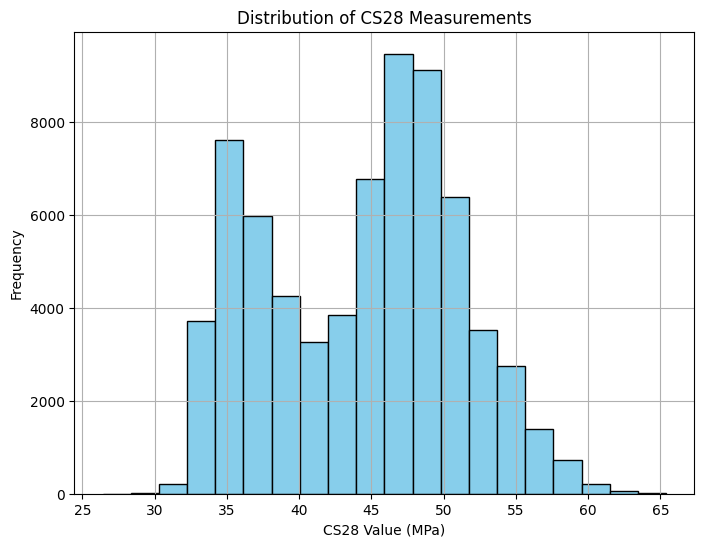

<IPython.core.display.Javascript object>

In [223]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df_all["CS28"], bins=20, color="skyblue", edgecolor="black")
plt.title("Distribution of CS28 Measurements")
plt.xlabel("CS28 Value (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

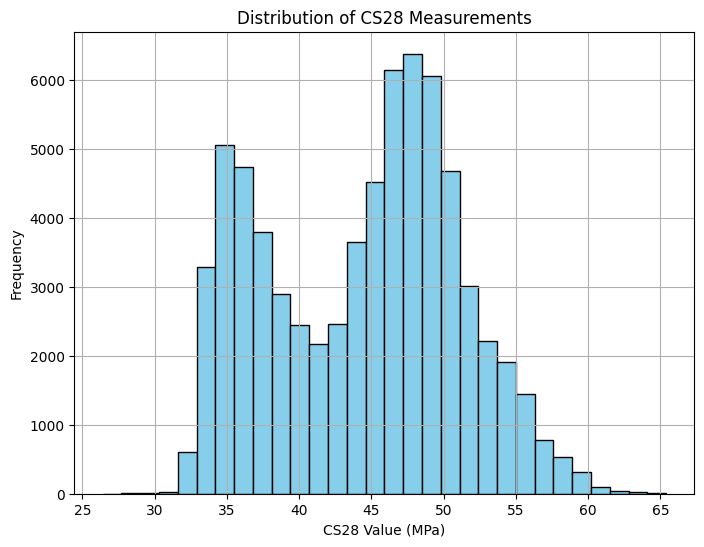

<IPython.core.display.Javascript object>

In [224]:
plt.figure(figsize=(8, 6))
plt.hist(df_all["CS28"], bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of CS28 Measurements")
plt.xlabel("CS28 Value (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

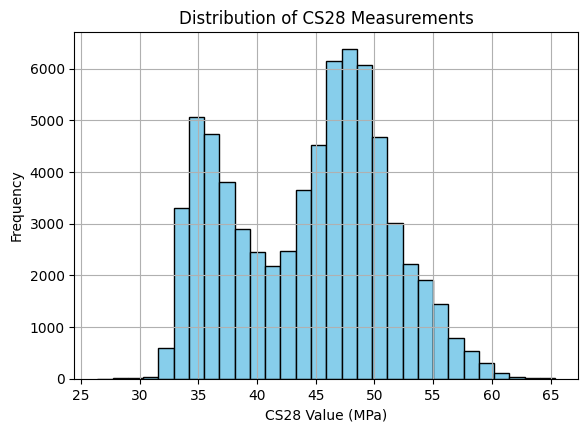

<IPython.core.display.Javascript object>

In [225]:
plt.figure(figsize=(6.5, 4.5))
plt.hist(df_all["CS28"], bins=30, linewidth=1, color="skyblue", edgecolor="black")
plt.title("Distribution of CS28 Measurements")
plt.xlabel("CS28 Value (MPa)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [226]:
df_all.shape

(69410, 66)

<IPython.core.display.Javascript object>

In [227]:
df2.select_dtypes(include="number").duplicated().any()

False

<IPython.core.display.Javascript object>

In [228]:
idx = df_all[df_all.select_dtypes(include="number").duplicated()].index
df_all.loc[idx]

,Date,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,TiO2,Fe2O3,...,%Clinker,Dehydration,Density,Factory,Cl-,Sieve 24 um,CO2,K2SO4,Sieve 32um,Sieve 45um


<IPython.core.display.Javascript object>

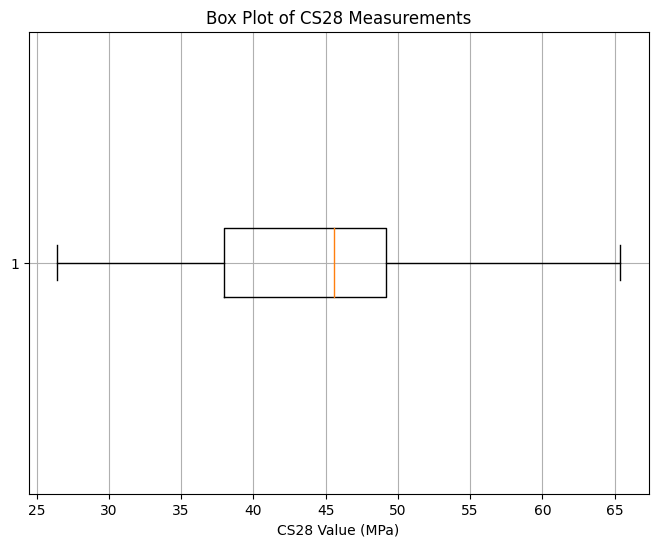

<IPython.core.display.Javascript object>

In [229]:
# Plot box plot
plt.figure(figsize=(8, 6))
plt.boxplot(df_all["CS28"], vert=False)
plt.title('Box Plot of CS28 Measurements')
plt.xlabel('CS28 Value (MPa)')
plt.grid(True)
plt.show()


In [230]:
import seaborn as sns

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: ylabel='CS28'>

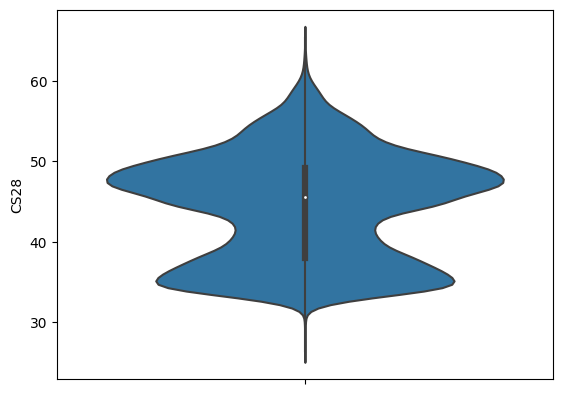

<IPython.core.display.Javascript object>

In [231]:
sns.violinplot(
    #x = "categorical_column",  # Column with categories
    y = df_all["CS28"],   # Column with numerical data
)


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CS28'>

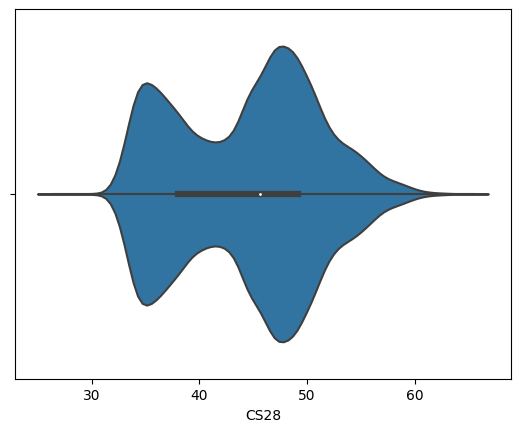

<IPython.core.display.Javascript object>

In [232]:
sns.violinplot(
    #x = "categorical_column",  # Column with categories
    x = df_all["CS28"],   # Column with numerical data
)


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CS28'>

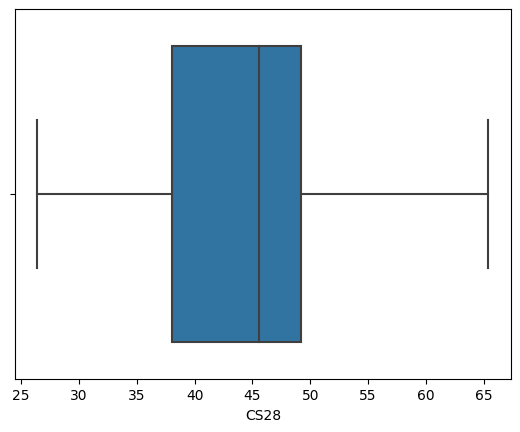

<IPython.core.display.Javascript object>

In [233]:
sns.boxplot(x=df_all["CS28"])

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CS28'>

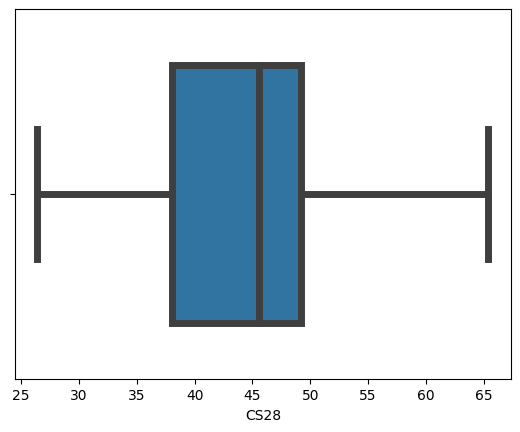

<IPython.core.display.Javascript object>

In [234]:
sns.boxplot(x=df_all["CS28"], linewidth=5, width=0.7)

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CS28'>

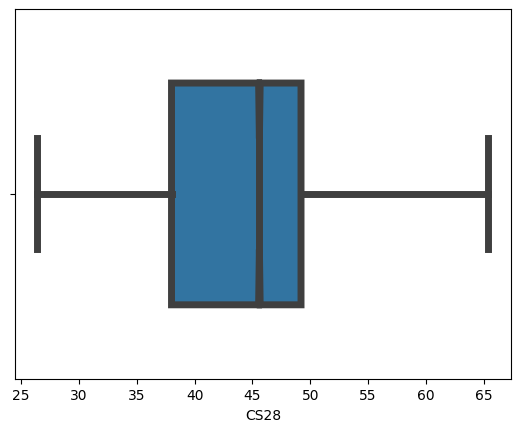

<IPython.core.display.Javascript object>

In [235]:
sns.boxplot(x=df_all["CS28"], linewidth=5, width=0.6, notch=True)

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CS28'>

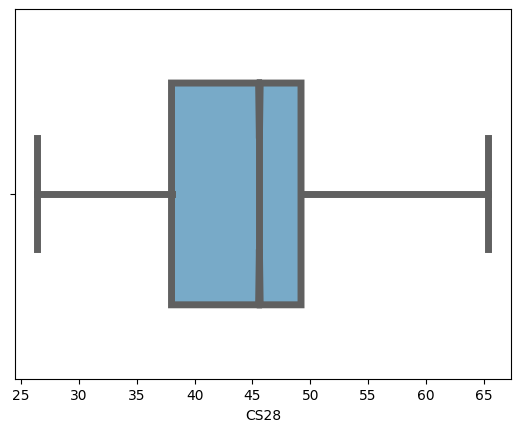

<IPython.core.display.Javascript object>

In [236]:
sns.boxplot(x=df_all["CS28"], linewidth=5, width=0.6, notch=True, palette="Blues")

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CS28'>

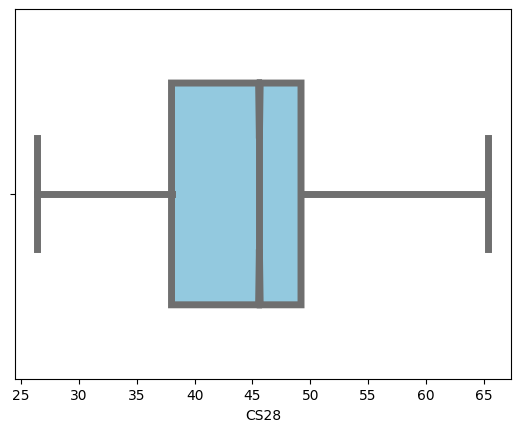

<IPython.core.display.Javascript object>

In [237]:
sns.boxplot(x=df_all["CS28"], linewidth=5, width=0.6, notch=True, color="skyblue")

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='CS28'>

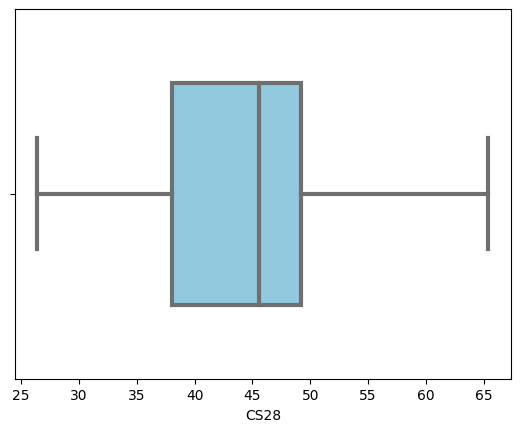

<IPython.core.display.Javascript object>

In [238]:
sns.boxplot(x=df_all["CS28"], linewidth=3, width=0.6, color="skyblue")

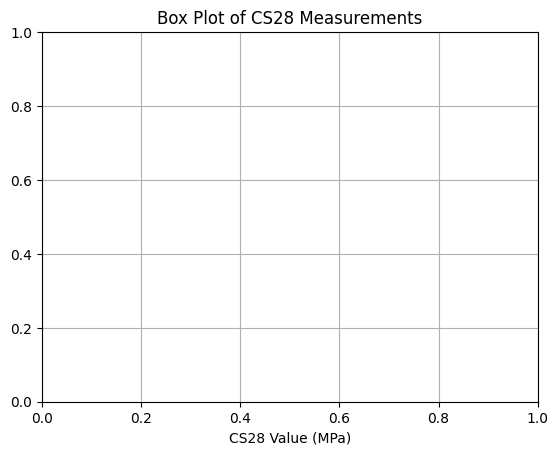

<IPython.core.display.Javascript object>

In [239]:
# Plot box plot
# plt.figure(figsize=(8, 6))
# plt.boxplot(df_all["CS28"], vert=False)
plt.title('Box Plot of CS28 Measurements')
plt.xlabel('CS28 Value (MPa)')
plt.grid(True)
plt.show()


/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


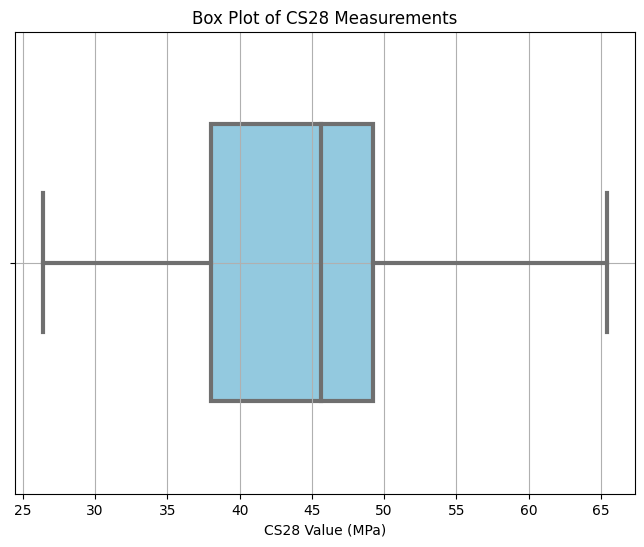

<IPython.core.display.Javascript object>

In [240]:
plt.figure(figsize=(8, 6))

sns.boxplot(x=df_all["CS28"], linewidth=3, width=0.6, color="skyblue")
plt.title("Box Plot of CS28 Measurements")
plt.xlabel("CS28 Value (MPa)")
plt.grid(True)
plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


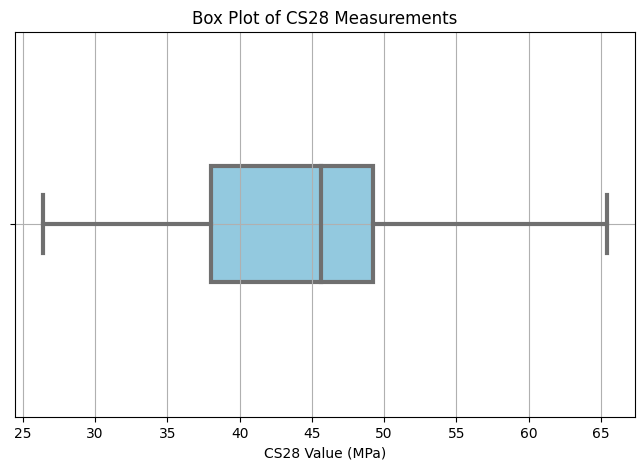

<IPython.core.display.Javascript object>

In [241]:
plt.figure(figsize=(8, 5))

sns.boxplot(x=df_all["CS28"], linewidth=3, width=0.3, color="skyblue")
plt.title("Box Plot of CS28 Measurements")
plt.xlabel("CS28 Value (MPa)")
plt.grid(True)
plt.show()

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


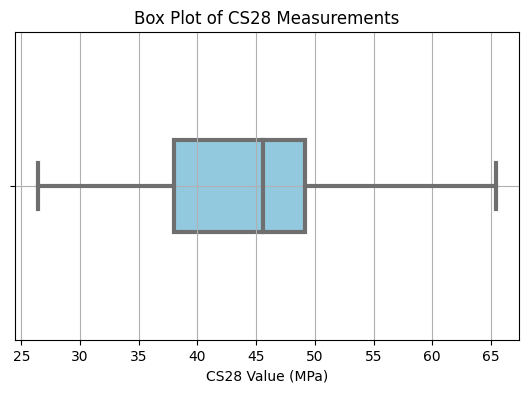

<IPython.core.display.Javascript object>

In [242]:
plt.figure(figsize=(6.5, 4))
sns.boxplot(x=df_all["CS28"], linewidth=3, width=0.3, color="skyblue")
plt.title("Box Plot of CS28 Measurements")
plt.xlabel("CS28 Value (MPa)")
plt.grid(True)
plt.show()


In [243]:
df_all["CS28"].value_counts()

CS28
47.000000    635
48.000000    517
49.000000    501
47.500000    451
46.000000    432
            ... 
39.287500      1
59.099998      1
47.705000      1
48.532500      1
65.400000      1
Name: count, Length: 3443, dtype: int64

<IPython.core.display.Javascript object>

In [244]:
df_all["CS28"].mode()

0    47.0
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [245]:
# calculate IQR for column Height
Q1 = df_all["CS28"].quantile(0.25)
Q3 = df_all["CS28"].quantile(0.75)
IQR = Q3 - Q1

<IPython.core.display.Javascript object>

In [246]:
IQR

11.200000762939403

<IPython.core.display.Javascript object>

In [247]:
Q1

38.0

<IPython.core.display.Javascript object>

In [248]:
Q3

49.2000007629394

<IPython.core.display.Javascript object>

In [249]:
38 - 49

-11

<IPython.core.display.Javascript object>

In [250]:
df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size().mean()

1542.4444444444443

<IPython.core.display.Javascript object>

In [251]:
df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size().std(ddof=0)

1122.8500554008003

<IPython.core.display.Javascript object>

In [252]:
df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size().describe()

count      45.000000
mean     1542.444444
std      1135.538029
min         9.000000
25%       933.000000
50%      1322.000000
75%      1733.000000
max      5888.000000
dtype: float64

<IPython.core.display.Javascript object>

In [253]:
df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size().mode().sum()

69410

<IPython.core.display.Javascript object>

In [254]:
df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size() == 1089

Factory_Plant
203_AV        False
203_C         False
203_D         False
203_G         False
203_M         False
203_Y         False
204_A         False
204_AB        False
204_AE        False
204_AQ        False
204_AY        False
204_F         False
204_I         False
204_O         False
204_R         False
204_T         False
206_B         False
207_AT        False
209_AA        False
209_AC        False
209_AG        False
209_AI        False
209_AM        False
209_AN        False
209_AP        False
209_AS        False
209_AW        False
209_AZ        False
209_E         False
209_H         False
209_J         False
209_K         False
209_L         False
209_N         False
209_P         False
209_Q         False
209_S         False
209_U         False
209_V         False
209_W          True
209_X         False
209_Z         False
partner_ii    False
partner_i    False
partner_iv         False
dtype: bool

<IPython.core.display.Javascript object>

In [255]:
# help(df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size().describe)

<IPython.core.display.Javascript object>

<Axes: >

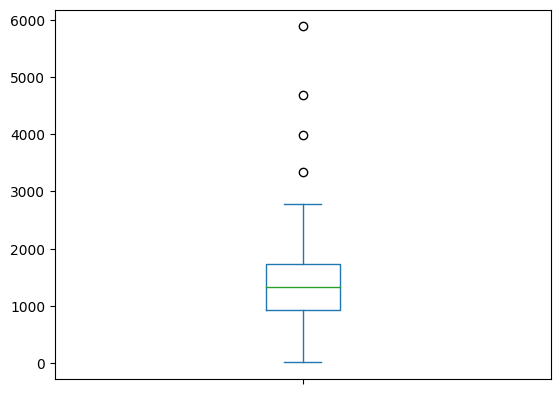

<IPython.core.display.Javascript object>

In [256]:
df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size().plot(
    kind="box"
)

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


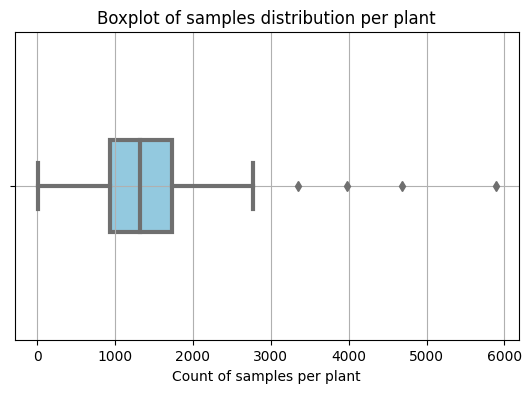

<IPython.core.display.Javascript object>

In [257]:
plt.figure(figsize=(6.5, 4))
sns.boxplot(x=df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size(), linewidth=3, width=0.3, color="skyblue")
plt.title("Boxplot of samples distribution per plant")
plt.xlabel("Count of samples per plant")
plt.grid(True)
plt.show()


In [258]:
df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size()

Factory_Plant
203_AV        1510
203_C         2773
203_D         4689
203_G         2006
203_M         5888
203_Y         1097
204_A         1461
204_AB        2316
204_AE        2002
204_AQ        1615
204_AY         975
204_F         2622
204_I          907
204_O         1322
204_R         1483
204_T         1012
206_B         1166
207_AT        1733
209_AA        1721
209_AC         763
209_AG         307
209_AI        1583
209_AM        3979
209_AN         890
209_AP         624
209_AS         494
209_AW           9
209_AZ        2044
209_E         1101
209_H         1789
209_J          708
209_K         3346
209_L         1482
209_N          933
209_P           50
209_Q         1552
209_S         1495
209_U         1087
209_V          710
209_W         1089
209_X          499
209_Z         1330
partner_ii    1057
partner_i    1233
partner_iv          958
dtype: int64

<IPython.core.display.Javascript object>

In [259]:
df2[df2["Factory"] == "209"]["Factory_Plant"].value_counts()

Factory_Plant
209_AM    3979
209_K     3346
209_AZ    2044
209_H     1789
209_AA    1721
209_AI    1583
209_Q     1552
209_S     1495
209_L     1482
209_Z     1330
209_E     1101
209_W     1089
209_U     1087
209_N      933
209_AN     891
209_AC     763
209_V      710
209_J      708
209_AP     624
209_X      499
209_AS     494
209_AG     307
209_P       50
209_AW       9
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [260]:
size = df_all[["Factory_Plant"]].fillna("partner_iv").groupby(["Factory_Plant"]).size()

<IPython.core.display.Javascript object>

In [261]:
((size >= 900) & (size <= 3000)).value_counts(normalize=True) * 100

True     68.888889
False    31.111111
Name: proportion, dtype: float64

<IPython.core.display.Javascript object>

In [262]:
size[size.index != "209_AW"].describe()

count      44.000000
mean     1577.295455
std      1124.057819
min        50.000000
25%       951.750000
50%      1326.000000
75%      1747.000000
max      5888.000000
dtype: float64

<IPython.core.display.Javascript object>

/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


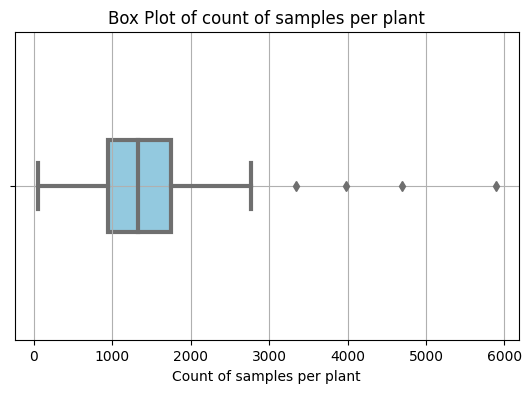

<IPython.core.display.Javascript object>

In [263]:
plt.figure(figsize=(6.5, 4))
sns.boxplot(x=size[size.index != "209_AW"], linewidth=3, width=0.3, color="skyblue")
plt.title("Box Plot of count of samples per plant")
plt.xlabel("Count of samples per plant")
plt.grid(True)
plt.show()


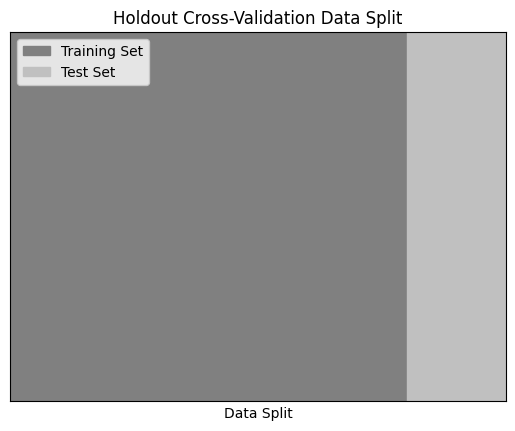

<IPython.core.display.Javascript object>

In [264]:
import matplotlib.pyplot as plt


def plot_holdout_split(train_ratio, colors=("#808080", "#C0C0C0")):
    """
    Generates an image with rectangles representing the data splitting for train and test sets in holdout cross-validation.

    Args:
        train_ratio (float): Ratio of the data used for training (between 0 and 1).
        colors (tuple, optional): Colors for the training and test rectangles. Defaults to ('#808080', '#C0C0C0').
    """

    # Calculate test ratio
    test_ratio = 1 - train_ratio

    # Create figure and axes
    fig, ax = plt.subplots()

    # Draw rectangles
    ax.add_patch(
        plt.Rectangle((0, 0), train_ratio, 1, color=colors[0], label="Training Set")
    )
    ax.add_patch(
        plt.Rectangle(
            (train_ratio, 0), test_ratio, 1, color=colors[1], label="Test Set"
        )
    )

    # Set plot limits and labels
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Data Split")
    ax.set_xticks([])
    ax.set_yticks([])

    # Add legend and title
    plt.legend()
    plt.title("Holdout Cross-Validation Data Split")

    # Show plot
    plt.show()


# Example usage
plot_holdout_split(train_ratio=0.8)

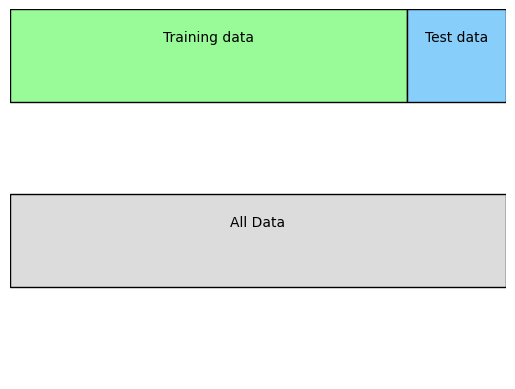

<IPython.core.display.Javascript object>

In [265]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_holdout_split(train_ratio, colors=('#98FB98', '#87CEFA', '#DCDCDC')):
  """
  Generates an image with rectangles representing data splitting for holdout cross-validation.

  Args:
      train_ratio (float): Ratio of data used for training (between 0 and 1).
      colors (tuple, optional): Colors for training, test, and all data rectangles. Defaults to green, blue, and light gray. 
  """
  # Calculate test ratio
  test_ratio = 1 - train_ratio

  # Create figure and axes
  fig, ax = plt.subplots()

  # Set up sizes and spacing 
  data_height = 0.05  
  data_spacing = 0.05
  text_y_offset = 0.01

  # "All Data" rectangle
  all_data_rect = patches.Rectangle((0, data_spacing), 1, data_height, facecolor=colors[2], edgecolor='black')
  ax.add_patch(all_data_rect)
  ax.text(0.5, data_spacing + data_height/2 + text_y_offset, 'All Data', ha='center', va='center')

  # "Training data" rectangle
  train_rect = patches.Rectangle((0, 2*data_spacing + data_height), train_ratio, data_height, facecolor=colors[0], edgecolor='black')
  ax.add_patch(train_rect)
  ax.text(train_ratio/2, 2*data_spacing + 1.5*data_height + text_y_offset, 'Training data', ha='center', va='center')

  # "Test data" rectangle
  test_rect = patches.Rectangle((train_ratio, 2*data_spacing + data_height), test_ratio, data_height, facecolor=colors[1], edgecolor='black')
  ax.add_patch(test_rect)
  ax.text(train_ratio + test_ratio/2, 2*data_spacing + 1.5*data_height + text_y_offset, 'Test data', ha='center', va='center')

  # Set plot limits and remove axes
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 2*data_spacing + 2*data_height)
  ax.axis('off')

  # Show plot
  plt.show()

# Example usage
plot_holdout_split(train_ratio=0.8)


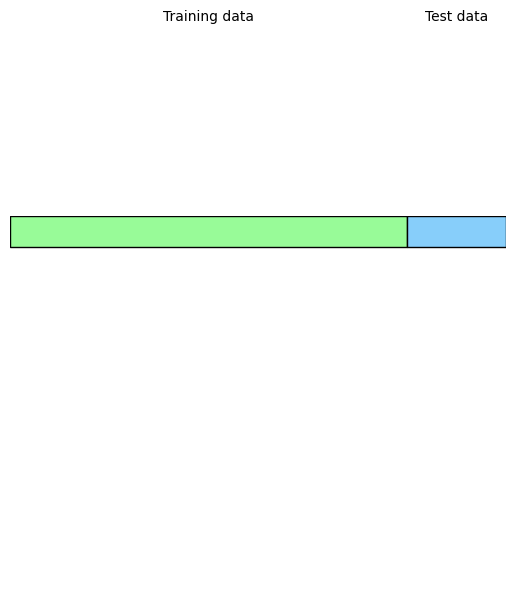

<IPython.core.display.Javascript object>

In [266]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_holdout_split(train_ratio, colors=("#98FB98", "#87CEFA", "#DCDCDC")):
    """
    Generates an image with rectangles representing data splitting for holdout cross-validation.

    Args:
        train_ratio (float): Ratio of data used for training (between 0 and 1).
        colors (tuple, optional): Colors for training, test, and all data rectangles. Defaults to green, blue, and light gray.
    """
    # Calculate test ratio
    test_ratio = 1 - train_ratio

    # Create figure and axes
    fig, ax = plt.subplots()

    # Set up sizes and spacing
    data_height = 0.01
    data_spacing = 0.05
    text_y_offset = 0.07

    #     # "All Data" rectangle
    #     all_data_rect = patches.Rectangle(
    #         (0, data_spacing), 1, data_height, facecolor=colors[2], edgecolor="black"
    #     )
    #     ax.add_patch(all_data_rect)
    #     ax.text(
    #         0.5,
    #         data_spacing + data_height / 2 + text_y_offset,
    #         "All Data",
    #         ha="center",
    #         va="center",
    #     )

    # "Training data" rectangle
    train_rect = patches.Rectangle(
        (0, 2 * data_spacing + data_height),
        train_ratio,
        data_height,
        facecolor=colors[0],
        edgecolor="black",
    )
    ax.add_patch(train_rect)
    ax.text(
        train_ratio / 2,
        2 * data_spacing + 1.5 * data_height + text_y_offset,
        "Training data",
        ha="center",
        va="center",
    )

    # "Test data" rectangle
    test_rect = patches.Rectangle(
        (train_ratio, 2 * data_spacing + data_height),
        test_ratio,
        data_height,
        facecolor=colors[1],
        edgecolor="black",
    )
    ax.add_patch(test_rect)
    ax.text(
        train_ratio + test_ratio / 2,
        2 * data_spacing + 1.5 * data_height + text_y_offset,
        "Test data",
        ha="center",
        va="center",
    )

    # Set plot limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2 * data_spacing + 2 * data_height)
    ax.axis("off")

    # Show plot
    plt.show()


# Example usage
plot_holdout_split(train_ratio=0.8)

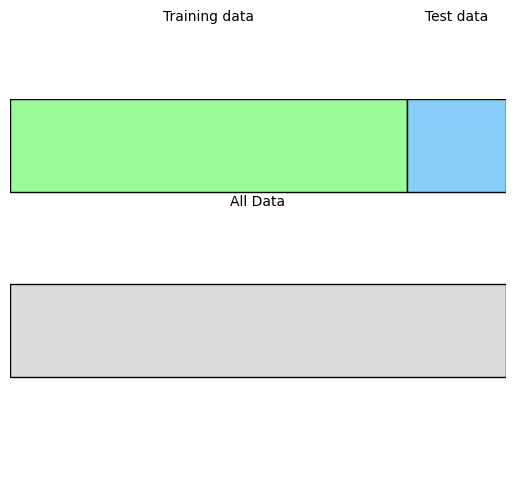

<IPython.core.display.Javascript object>

In [267]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_holdout_split(train_ratio, colors=("#98FB98", "#87CEFA", "#DCDCDC")):
    """
    Generates an image with rectangles representing data splitting for holdout cross-validation.

    Args:
        train_ratio (float): Ratio of data used for training (between 0 and 1).
        colors (tuple, optional): Colors for training, test, and all data rectangles. Defaults to green, blue, and light gray.
    """
    # Calculate test ratio
    test_ratio = 1 - train_ratio

    # Create figure and axes
    fig, ax = plt.subplots()

    # Set up sizes and spacing
    data_height = 0.05
    data_spacing = 0.05
    text_y_offset = 0.07

    # "All Data" rectangle
    all_data_rect = patches.Rectangle(
        (0, data_spacing), 1, data_height, facecolor=colors[2], edgecolor="black"
    )
    ax.add_patch(all_data_rect)
    ax.text(
        0.5,
        data_spacing + data_height / 2 + text_y_offset,
        "All Data",
        ha="center",
        va="center",
    )

    # "Training data" rectangle
    train_rect = patches.Rectangle(
        (0, 2 * data_spacing + data_height),
        train_ratio,
        data_height,
        facecolor=colors[0],
        edgecolor="black",
    )
    ax.add_patch(train_rect)
    ax.text(
        train_ratio / 2,
        2 * data_spacing + 1.5 * data_height + text_y_offset,
        "Training data",
        ha="center",
        va="center",
    )

    # "Test data" rectangle
    test_rect = patches.Rectangle(
        (train_ratio, 2 * data_spacing + data_height),
        test_ratio,
        data_height,
        facecolor=colors[1],
        edgecolor="black",
    )
    ax.add_patch(test_rect)
    ax.text(
        train_ratio + test_ratio / 2,
        2 * data_spacing + 1.5 * data_height + text_y_offset,
        "Test data",
        ha="center",
        va="center",
    )

    # Set plot limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 2 * data_spacing + 2 * data_height)
    ax.axis("off")

    # Customize font size (adjust as needed)
    plt.rcParams.update({"font.size": 12})

    # Save the plot as a PNG image
    plt.savefig("holdout_80_20_split.png", dpi=300, bbox_inches="tight")

    # Show plot
    plt.show()


# Generate the plot with 80% / 20% split
plot_holdout_split(train_ratio=0.8)

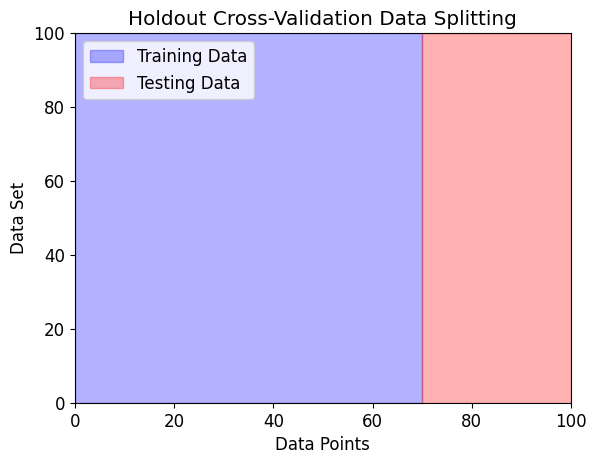

<IPython.core.display.Javascript object>

In [268]:
import matplotlib.pyplot as plt

def plot_holdout_cv(data_size, train_size, test_size):
    fig, ax = plt.subplots()
    
    # Plotting the training data rectangle
    ax.add_patch(plt.Rectangle((0, 0), train_size, data_size, alpha=0.3, color='blue', label='Training Data'))
    
    # Plotting the testing data rectangle
    ax.add_patch(plt.Rectangle((train_size, 0), test_size, data_size, alpha=0.3, color='red', label='Testing Data'))
    
    ax.set_xlim(0, train_size + test_size)
    ax.set_ylim(0, data_size)
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Data Set')
    ax.set_title('Holdout Cross-Validation Data Splitting')
    ax.legend()
    plt.show()

# Example usage:
data_size = 100
train_size = 70
test_size = 30
plot_holdout_cv(data_size, train_size, test_size)


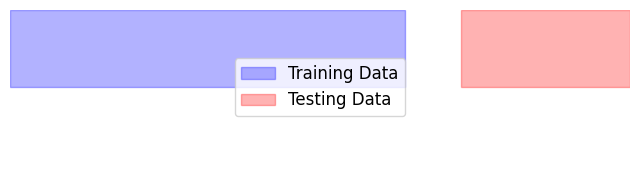

<IPython.core.display.Javascript object>

In [269]:
import matplotlib.pyplot as plt

def plot_holdout_cv(data_size, train_size, test_size):
    fig, ax = plt.subplots(figsize=(8,2))
    
    # Plotting the training data rectangle
    ax.add_patch(plt.Rectangle((0, 0.5), train_size, 0.5, alpha=0.3, color='blue', label='Training Data'))
    
    # Plotting the testing data rectangle
    ax.add_patch(plt.Rectangle((train_size + 0.1, 0.5), test_size, 0.5, alpha=0.3, color='red', label='Testing Data'))
    
    ax.set_xlim(0, train_size + test_size + 0.1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.legend(loc='center')
    plt.show()

# Example usage:
data_size = 1
train_size = 0.7
test_size = 0.3
plot_holdout_cv(data_size, train_size, test_size)


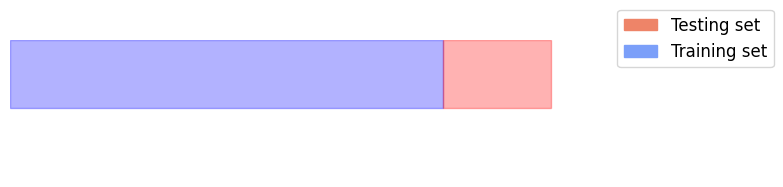

<IPython.core.display.Javascript object>

In [270]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_holdout_cv(data_size, train_size, test_size):
    cmap_cv = plt.cm.coolwarm
    fig, ax = plt.subplots(figsize=(8,2))
    
    # Plotting the training data rectangle
    ax.add_patch(plt.Rectangle((0, 0.5), train_size, 0.5, alpha=0.3, color='blue', label='Training Set'))
    
    # Plotting the testing data rectangle
    ax.add_patch(plt.Rectangle((train_size, 0.5), test_size, 0.5, alpha=0.3, color='red', label='Testing Set'))
    
    ax.set_xlim(0, train_size + test_size + 0.1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.legend(loc='best', bbox_to_anchor=(train_size-0.13, test_size + 0.25, 0.5, 0.5))
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.2))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    plt.tight_layout()
    
    plt.show()
    # help(ax.legend)

# Example usage:
data_size = 1
train_size = 0.8
test_size = 0.2
plot_holdout_cv(data_size, train_size, test_size)


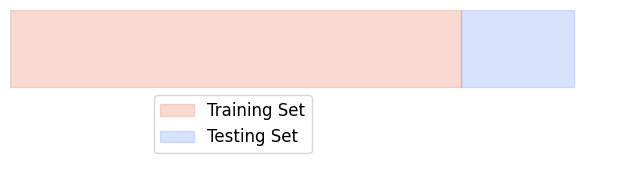

<IPython.core.display.Javascript object>

In [271]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_holdout_cv(data_size, train_size, test_size):
    cmap_cv = plt.cm.coolwarm
    fig, ax = plt.subplots(figsize=(8,2))
    
    # Plotting the training data rectangle
    train_rect = ax.add_patch(plt.Rectangle((0, 0.5), train_size, 0.5, alpha=0.3, color=cmap_cv(0.8), label='Training Set'))
    
    # Plotting the testing data rectangle
    test_rect = ax.add_patch(plt.Rectangle((train_size, 0.5), test_size, 0.5, alpha=0.3, color=cmap_cv(0.2), label='Testing Set'))
    
    ax.set_xlim(0, train_size + test_size + 0.1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    ax.legend(handles=[train_rect, test_rect], loc='best', bbox_to_anchor=(0.5, 0.5))
    
    plt.show()

# Example usage:
data_size = 1
train_size = 0.8
test_size = 0.2
plot_holdout_cv(data_size, train_size, test_size)


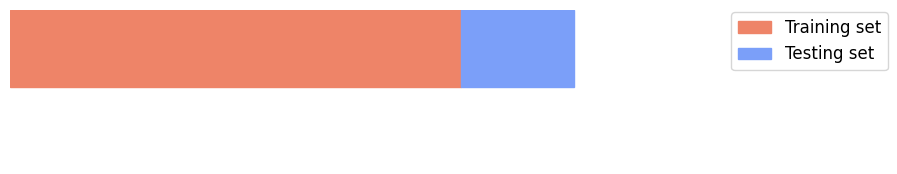

<IPython.core.display.Javascript object>

In [272]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_holdout_cv(data_size, train_size, test_size):
    cmap_cv = plt.cm.coolwarm
    fig, ax = plt.subplots(figsize=(8,2))
    
    # Plotting the training data rectangle
    train_rect = ax.add_patch(plt.Rectangle((0, 0.5), train_size, 0.5, color=cmap_cv(0.8), label='Training Set'))
    
    # Plotting the testing data rectangle
    test_rect = ax.add_patch(plt.Rectangle((train_size, 0.5), test_size, 0.5, color=cmap_cv(0.2), label='Testing Set'))
          
    ax.set_xlim(0, train_size + test_size + 0.1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    ax.legend([train_rect, test_rect], ['Training set', 'Testing set'], loc='best', bbox_to_anchor=(1.15, 1.04))
    
    plt.show()

# Example usage:
data_size = 1
train_size = 0.8
test_size = 0.2
plot_holdout_cv(data_size, train_size, test_size)


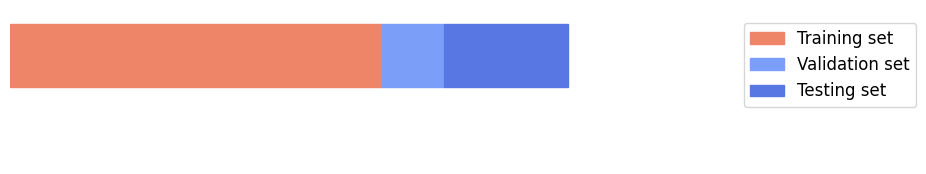

<IPython.core.display.Javascript object>

In [273]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_holdout_cv(data_size, train_size, test_size, val_size):
    cmap_cv = plt.cm.coolwarm
    fig, ax = plt.subplots(figsize=(8,2))
    
    # Plotting the training data rectangle
    train_rect = ax.add_patch(plt.Rectangle((0, 0.5), train_size, 0.41, color=cmap_cv(0.8), label='Training Set'))
    
    # Plotting the validation data rectangle
    val_rect = ax.add_patch(plt.Rectangle((train_size, 0.5), val_size, 0.41, color=cmap_cv(0.2), label='Validation Set'))
    
    # Plotting the testing data rectangle
    test_rect = ax.add_patch(plt.Rectangle((train_size + val_size, 0.5), test_size, 0.41, color=cmap_cv(0.1), label='Testing Set'))
          
    ax.set_xlim(0, train_size + val_size + test_size + 0.1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    ax.legend([train_rect, val_rect, test_rect], ['Training set', 'Validation set', 'Testing set'], loc='best', bbox_to_anchor=(1.17, 0.97))
    
    plt.show()

# Example usage:
data_size = 1
train_size = 0.6
val_size = 0.1
test_size = 0.2
plot_holdout_cv(data_size, train_size, test_size, val_size)


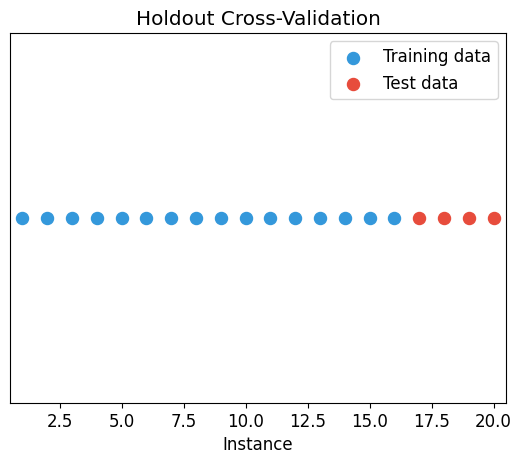

<IPython.core.display.Javascript object>

In [274]:
import matplotlib.pyplot as plt


def plot_holdout_timeline(train_ratio, num_instances=20, colors=("#3498db", "#e74c3c")):
    """
    Creates a timeline-style plot for holdout cross-validation.

    Args:
      train_ratio (float): Ratio of data used for training (between 0 and 1).
      num_instances (int, optional): Number of instances to display in the timeline. Defaults to 20.
      colors (tuple, optional): Colors for training and test instances. Defaults to blue and red.
    """
    # Calculate split point
    split_point = int(train_ratio * num_instances)

    # Create figure and axes
    fig, ax = plt.subplots()

    # Create timeline
    timeline = range(1, num_instances + 1)

    # Plot training data
    ax.scatter(
        timeline[:split_point],
        [1] * split_point,
        marker="o",
        s=75,
        color=colors[0],
        label="Training data",
    )

    # Plot test data
    ax.scatter(
        timeline[split_point:],
        [1] * (num_instances - split_point),
        marker="o",
        s=75,
        color=colors[1],
        label="Test data",
    )

    # Set plot limits and labels
    ax.set_ylim(0.5, 1.5)
    ax.set_xlim(0.5, num_instances + 0.5)
    ax.set_xlabel("Instance")
    ax.set_yticks([])

    # Add title and legend
    plt.title("Holdout Cross-Validation")
    plt.legend()

    # Customize appearance
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    # Show plot
    plt.show()


# Example usage
plot_holdout_timeline(train_ratio=0.80)

In [275]:
plt.figure(figsize=(6.5, 4))


<Figure size 650x400 with 0 Axes>

<Figure size 650x400 with 0 Axes>

<IPython.core.display.Javascript object>